<div id="container" style="position:relative;">
<div style="float:left"><h1>Issued Building Permits in Vancouver Canada</h1></div>
<div style="position:relative; float:right">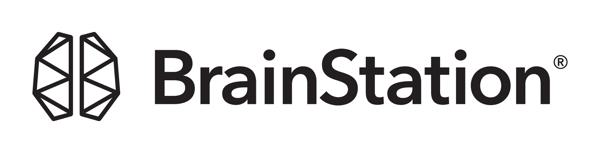
</div>
</div>


**Author:** Tatyana Mozgacheva

## Table of Contents

[Setting up a Python environment](#Setting-up-a-Python-environment) 

[Introduction](#Introduction) 

[1. Loading data & checking high-level details](#1.-Loading-data-&-checking-high-level-details) <br>
- [Data Dictionary](#Data-Dictionary) <br>

[2. Data preparation and cleaning](#Data-preparation-and-cleaning) <br>

[3. Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Univariate Visualizations](#Univariate-Visualizations) <br>
- [Multivariate Visualizations](#Multivariate-Visualizations) <br>
- [Time Series](#Time-Series) <br>

[4. EDA Conclusion](#EDA-Conclusion) <br>
[5. Feature Engineering](#Feature-Engineering)<br>
[6. Baseline models](#Baseline-models)
- [Linear Regression model](#Linear-Regression-model) <br>
- [Ridge model](#Ridge-model) <br>
- [Decision Tree model](#Decision-Tree-model) <br>
- [Polynomial Regression](#Polynomial-Regression) <br>

[7. XGBoost Regressor model](#XGBoost-Regressor-model)

## Setting up a Python environment
Create the required `building_permit` environment for this notebook:

conda create -n building_permit python=3.8 numpy pandas matplotlib seaborn jupyter jupyterlab scikit-learn=0.24.1

conda activate building_permit

conda install -c plotly plotly=4.12.0

conda install -c bokeh bokeh=2.2.3

conda install streamlit

pip install --upgrade streamlit

pip install --upgrade plotly

pip install nltk

pip install shap

ipython kernel install --name "building_permit" --user

In [94]:
import time

# Data Visualization and Exploration
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot
from scipy import stats
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind
from statsmodels.graphics.tsaplots import month_plot
from plotly.subplots import make_subplots
import plotly.graph_objs as go

#Data Processing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from statsmodels.api import tsa

# NLP
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string

#Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

#Model Evaluation and Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import shap

#Time Series Analysis
from statsmodels.api import tsa # time series analysis

#Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#For saving model locally
import pickle

# Introduction

## Dataset
Throughout this notebook I will use the `issued-building-permits.csv` dataset. 

Building permits are required for new buildings, additions or alterations to existing buildings, and for demolitions or salvage and abatement work.

You can download the dataset from [here](https://opendata.vancouver.ca/explore/dataset/issued-building-permits/export/)

The GitHub project is [here](https://github.com/tmozgach/brainstation_capstone_building_permits) 

## Question of interest

> Does the time it takes to obtain a permit relate to factors like property values, type of work, property use, and location, etc?

## 1. Loading data & checking high-level details

In [95]:
# Read the CSV file 'issued-building-permits.csv' into a DataFrame,
# using ';' as the delimiter
df = pd.read_csv('issued-building-permits.csv', delimiter=";")

# Filter out rows where the 'IssueYear' column is not equal to 2024,
#because 2024 doesn't have full year data.
df = df[df['IssueYear'] != 2024]

# Filter out rows where the 'IssueYear' column is equal to 2013, 2014, 2015, or 2016
# This is done to address potential data quality issues related to changes in permit software
# and to focus the analysis on relevant data
df = df[df['IssueYear'] != 2013]
df = df[df['IssueYear'] != 2014]
df = df[df['IssueYear'] != 2015]
df = df[df['IssueYear'] != 2016]

# Display the first few rows of the DataFrame
df.head()

PermitNumber PermitNumberCreatedDate   IssueDate  PermitElapsedDays  \
0  DB-2023-00041              2023-01-05  2023-04-28                113   
1  BP-2023-00049              2023-01-06  2023-03-29                 82   
2  DB-2023-00050              2023-01-06  2023-09-12                249   
3  DB-2023-00064              2023-01-06  2023-10-04                271   
4  DB-2023-00065              2023-01-06  2023-03-31                 84   

   ProjectValue             TypeOfWork  \
0      198847.5           New Building   
1           0.0  Salvage and Abatement   
2     1068777.5           New Building   
3      155030.0           New Building   
4      692250.0           New Building   

                                     Address  \
0        7475 DUMFRIES STREET, Vancouver, BC   
1  1137 E 29TH AVENUE, Vancouver, BC V5V 2S7   
2    85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5   
3         95 E 59TH AVENUE #3, Vancouver, BC   
4                                        NaN   

                                  ProjectDescription  \
0  Low Density Housing - New Building - To constr...   
1  Low Density Housing - Salvage and Abatement - ...   
2  Low Density Housing - New Building - To constr...   
3  Low Density Housing - New Building - To constr...   
4  Low Density Housing - New Building - To constr...   

                    PermitCategory  \
0   New Build - Standalone Laneway   
1                              NaN   
2  New Build - Low Density Housing   
3   New Build - Standalone Laneway   
4  New Build - Low Density Housing   

                                    Applicant  \
0                          Shalindro  Dosanjh   
1  John Keen DBA: Farpoint Architectural Inc.   
2          Embark Homes DBA: Embark Homes LTD   
3      Wayne  Ng DBA: Skymark Engineering Ltd   
4           Jordan Talhan DBA: 0686632 BC LTD   

                                  ApplicantAddress    PropertyUse  \
0   1185 49 th Ave West\r\nVancouver,, BC  V6M 2P9  Dwelling Uses   
1    1662 West 75th Ave.\r\nVancouver, BC  V6P 6G2  Dwelling Uses   
2  501-4289 Hastings Street\r\nBurnaby, BC  V5C0K9  Dwelling Uses   
3        3383 Queens Ave\r\nVancouver, BC  V5R 4T9  Dwelling Uses   
4          12945 56A Avenue \r\nSurrey, BC  V3X2Z1  Dwelling Uses   

                 SpecificUseCategory  \
0                      Laneway House   
1              Single Detached House   
2  Single Detached House w/Sec Suite   
3                      Laneway House   
4           Duplex w/Secondary Suite   

                         BuildingContractor  \
0             Amcata Homes Developments Ltd   
1  Vancouver Excavating and Contracting Ltd   
2                          Embark Homes LTD   
3                   Semlin Construction Ltd   
4                Rungur Sherhomes Group Ltd   

                    BuildingContractorAddress  IssueYear  \
0  1185 W 49TH AV  \r\nVancouver, BC  V6M 2P9       2023   
1     25 Howard Ave  \r\nBurnaby, BC  V5B 3P3       2023   
2                                         NaN       2023   
3    949 Esmond Ave  \r\nBurnaby, BC  V5C 6A6       2023   
4                                         NaN       2023   

               GeoLocalArea  \
0       Victoria-Fraserview   
1  Kensington-Cedar Cottage   
2                  Oakridge   
3                    Sunset   
4                       NaN   

                                                Geom YearMonth  \
0  {"coordinates": [-123.0755831, 49.2165995], "t...   2023-04   
1  {"coordinates": [-123.081827, 49.244843], "typ...   2023-03   
2  {"coordinates": [-123.1079161, 49.2270346], "t...   2023-09   
3  {"coordinates": [-123.1041746, 49.2170343], "t...   2023-10   
4                                                NaN   2023-03   

               geo_point_2d  
0  49.2165995, -123.0755831  
1    49.244843, -123.081827  
2  49.2270346, -123.1079161  
3  49.2170343, -123.1041746  
4                       NaN

### Data Dictionary

| Field Name | Type | Description | Sample |
|------------|------|-------------|--------|
| PermitNumber | text | Unique permit number generated at application date; there may be multiple permits for one project site BU - Original Permit application was made in previous software BP - Building Permit DB - Combined Development & Building Permit | BP-2019-04164 |
| PermitNumberCreatedDate | date | The date at which a permit application, created by staff or an online process, receives a permit number | 2019-09-17 |
| IssueDate | date | Date when the specified permit was first issued | 2019-11-15 |
| PermitElapsedDays | integer | Measures the number of days from the creation and assignment of a permit number until the issuance of a permit.  Application processing represents a collaboration between the applicant/customer team and the City.  Timelines may be influenced by a number of factors, some of which include: the volume of instream applications to be processed, completeness of the application, site and project specific requirements impacting application requirements (number of reviews, conditions, design decisions, etc.), staff and customer response times. | 59 |
| ProjectValue | decimal | Estimated construction value at time of original permit issuance; base permit fees are calculated on this value. For commercial and mixed-use projects with multiple buildings on one site, the project value may be entered only on the site permit (and not the permits for each individual building where a $0 value will be shown) | 0 |
| TypeOfWork | text | Categories Include: Addition / Alteration, Demolition / Deconstruction, New Buildings, Outdoor Uses (No Buildings Proposed), Salvage and Abatement, Temporary Buildings / Structures | Salvage and Abatement |
| Address | text | Specific Property Address | 4094 W 30TH AVENUE, Vancouver, BC V6S 1X5 |
| ProjectDescription | text | Scope of work (note: data file prior to 2018 does not include this field) | Low Density Housing - Salvage and Abatement - SALVAGE AND ABATEMENT PERMIT Salvage and Abatement Permit only for Building permit: DB-2019-04161 and to be completed under the supervision of a registered professional.  This permit does not authorize demolition, deconstruction or construction work. QP:  MCA Environmental Consulting Inc. (Tarlochan (Terry) Sunar) Demolition permit: DB-2019-04162 |
| PermitCategory | text | A high level grouping providing a focus on higher volume, lower complexity project scopes. The categorization is derived from data in the TypeofWork, PropertyUse and ProjectDescription fields. This field was added in December 2021 and will be modified to take into account feedback from dataset users | - |
| Applicant | text | Applicant may be property owner or official agent for owner and is often the design professional or their firm | Scott Posno DBA: Scott Posno Design |
| ApplicantAddress | text | Contact information as provided on Permit Application | 1595 W 3rd Avenue Vancouver, BC  V6J 1J8 |
| PropertyUse | text | General use of property; where there is more than one, they are separated by a comma | Dwelling Uses |
| SpecificUseCategory | text | Category of property use; where there is more than one, they are separated by a comma | Single Detached House |
| BuildingContractor | text | Contractor information, if known, at time of permit issuance | Mercia Construction Ltd |
| BuildingContractorAddress | text | Contractor information, as provided by the applicant | - |
| IssueYear | text | Year which permit was first issued | 2019 |
| GeoLocalArea | text | The local area where the building with the Issued Building Permit is found, derived from the building's coordinates or address. The City of Vancouver has 22 local areas (also known as local planning areas). For more details, please see the Local Area Boundary data set. | Dunbar-Southlands |
| Geom | geo shape | These are mapping coordinates for the building corresponding to a Building Permit. Data from the Address attribute are processed by the BC Address Geocoder API. An unmatched address returns null coordinates and will not display on the Map. The permit will still be listed in the Table view. | {"coordinates":[-123.1965627,49.2450036],"type":"Point"} |
| YearMonth | text | No description available for this field. | 2019-11 |
| geo_point_2d | geo point | No description available for this field. | [49.2450036,-123.1965627] |



In [96]:
# Display the last few rows of the DataFrame
df.tail()

PermitNumber PermitNumberCreatedDate   IssueDate  PermitElapsedDays  \
39552  BP-2023-02460              2023-07-12  2023-11-09                120   
39553  BP-2023-02461              2023-07-12  2023-09-25                 75   
39555  DB-2023-02482              2023-07-13  2023-10-20                 99   
39557  DB-2023-02489              2023-07-13  2023-09-27                 76   
39558  BP-2021-01316              2021-04-06  2021-08-16                132   

       ProjectValue             TypeOfWork  \
39552     2200000.0  Addition / Alteration   
39553           0.0  Salvage and Abatement   
39555     1200000.0           New Building   
39557      676000.0           New Building   
39558      129000.0  Addition / Alteration   

                                           Address  \
39552  1090 W PENDER STREET, Vancouver, BC V6E 2N7   
39553    3781 W 18TH AVENUE, Vancouver, BC V6S 1B3   
39555    3569 W 30TH AVENUE, Vancouver, BC V6S 1W6   
39557    2616 NAPIER STREET, Vancouver, BC V5K 2W6   
39558      2920 VIRTUAL WAY, Vancouver, BC V5M 0C4   

                                      ProjectDescription  \
39552  Certified Professional Program - Addition / Al...   
39553  Low Density Housing - Salvage and Abatement - ...   
39555  Low Density Housing - New Building - To constr...   
39557  Low Density Housing - New Building - To constr...   
39558  Field Review - Addition / Alteration - #30 \r\...   

                                          PermitCategory  \
39552                                                NaN   
39553                                                NaN   
39555                    New Build - Low Density Housing   
39557                    New Build - Low Density Housing   
39558  Renovation - Commercial/ Mixed Use - Lower Com...   

                                               Applicant  \
39552  Robert Heikkila DBA: CFT Engineering Inc., a J...   
39553                TIMOTHY TSE DBA: Cadlab Design Inc.   
39555  Danny Lung & Sharon Chen DBA: Lung Designs Gro...   
39557                                        Kuldip Brar   
39558  Jan Van de fliert DBA: BLUE ROCK Construction ...   

                                        ApplicantAddress    PropertyUse  \
39552  #500 - 1901 Rosser Avenue\r\nBurnaby, BC  V5C 6R6    Office Uses   
39553        225-8877 Odlin Cr.\r\nRichmond, BC  V6X 3Z7  Dwelling Uses   
39555  LUNG DESIGNS GROUP LTD\r\nUNIT 268-2633 VIKING...  Dwelling Uses   
39557  1244 grand boulevard east\r\nnorth vancouver, ...  Dwelling Uses   
39558  43 auburn meadows crescent SE\r\nCalgary, AB  ...    Retail Uses   

                            SpecificUseCategory  \
39552                            General Office   
39553                     Single Detached House   
39555  Secondary Suite,Duplex w/Secondary Suite   
39557                                    Duplex   
39558                              Retail Store   

                          BuildingContractor  \
39552                                    NaN   
39553              Townhill Development Inc.   
39555                       RBC Holdings Ltd   
39557                  Brar Empire Homes Ltd   
39558  Blue Rock Construction Management Ltd   

                               BuildingContractorAddress  IssueYear  \
39552                                                NaN       2023   
39553                                                NaN       2023   
39555        4112 HEATHER ST  \r\nVancouver, BC  V5Z 0B5       2023   
39557  1244 Grand Blvd  \r\nNorth Vancouver, BC  V7L 3X4       2023   
39558  43 Auburn Meadows Cres SE  \r\nCalgary, AB  T3...       2021   

              GeoLocalArea                                               Geom  \
39552             Downtown  {"coordinates": [-123.1202195, 49.2871644], "t...   
39553    Dunbar-Southlands  {"coordinates": [-123.1876529, 49.2567512], "t...   
39555    Dunbar-Southlands  {"coordinates": [-123.1839825, 49.2454866], "t...   
39557     Hastings-Sunrise  {"coordinates": [-123.

In [97]:
# Display a random sample of 15 rows from the DataFrame
df.sample(15)

PermitNumber PermitNumberCreatedDate   IssueDate  PermitElapsedDays  \
26274  DB-2021-00066              2021-01-08  2021-04-13                 95   
24540  BP-2018-05657              2018-10-29  2019-01-15                 78   
7049   BP-2018-02195              2018-04-23  2018-06-20                 58   
13103  DB-2022-02372              2022-05-05  2022-10-18                166   
36581  DB-2022-02418              2022-05-06  2022-08-03                 89   
22284  DB-2018-00198              2018-01-15  2018-10-22                280   
6445   BP-2017-06177              2017-11-28  2018-01-31                 64   
8892   DB-2022-00401              2022-01-31  2022-03-24                 52   
37063  DB-2023-00053              2023-01-06  2023-08-11                217   
35372  BP-2023-04405              2023-12-01  2023-12-07                  6   
39531  DB-2021-01251              2021-03-31  2021-11-26                240   
25767  DB-2019-01916              2019-05-06  2019-09-25                142   
29818  BP-2018-05332              2018-10-11  2018-10-24                 13   
30556  BP-2020-00021              2020-01-03  2020-04-16                104   
1401   BP-2018-05833              2018-11-08  2019-01-02                 55   

       ProjectValue                   TypeOfWork  \
26274     175000.00                 New Building   
24540      10000.00        Addition / Alteration   
7049       30000.00        Addition / Alteration   
13103      50000.00  Demolition / Deconstruction   
36581      12000.00        Addition / Alteration   
22284     254156.88                 New Building   
6445           0.00        Addition / Alteration   
8892      175000.00        Addition / Alteration   
37063     744610.00                 New Building   
35372          0.00        Salvage and Abatement   
39531    1000000.00                 New Building   
25767     818072.50                 New Building   
29818     250000.00        Addition / Alteration   
30556     200000.00        Addition / Alteration   
1401           0.00        Salvage and Abatement   

                                             Address  \
26274    126 E 48TH AVENUE #3, Vancouver, BC V5W 2C8   
24540   2203 GRANVILLE STREET, Vancouver, BC V6H 3G1   
7049    5701 GRANVILLE STREET, Vancouver, BC V6M 4J7   
13103             3629 ARBUTUS STREET, Vancouver, BC   
36581    3860 GLENDALE STREET, Vancouver, BC V5R 1C5   
22284       953 E 53RD AVENUE, Vancouver, BC V1V 1V1   
6445             3550 SE MARINE DRIVE, Vancouver, BC   
8892       1035 ROBSON STREET, Vancouver, BC V6E 4A9   
37063       2710 E 1ST AVENUE, Vancouver, BC V5M 1A7   
35372      3772 W 20TH AVENUE, Vancouver, BC V6S 1E8   
39531      1528 W 57TH AVENUE, Vancouver, BC V6P 1T2   
25767       108 E 56TH AVENUE, Vancouver, BC V5X 1R1   
29818      595 BURRARD STREET, Vancouver, BC V7X 1K8   
30556  2890 GRANDVIEW HIGHWAY, Vancouver, BC V5M 2C9   
1401       4445 WALDEN STREET, Vancouver, BC V5V 3S4   

                                      ProjectDescription  \
26274  Low Density Housing - New Building - To constr...   
24540  Field Review - Addition / Alteration - 2203 Gr...   
7049   Field Review - Addition / Alteration - #106 In...   
13103  Enquiry Centre - Demolition / Deconstruction -...   
36581  Field Review - Addition / Alteration - Exterio...   
22284  Low Density Housing - New Building - To constr...   
6445   Enquiry Centre - Addition / Alteration - 3550 ...   
8892   Field Review - Addition / Alteration - Exterio...   
37063  Low Density Housing - New Building - To constr...   
35372  Low Density Housing - Salvage and Abatement - ...   
39531  Low Density Housing - New Building - 2 FD + 2 ...   
25767  Low Density Housing - New Building - To constr...   
29818  Field Review - Addition / Alteration -  #833- ...   
30556  High Density Housing / Commercial - Addition /...   
1401   Low Density Housing - Salvage and Abatement - ...   

                                          PermitCate

In [98]:
# Retrieve the shape of the DataFrame, which represents the number of rows and columns
df.shape

(39082, 20)

In [99]:
# Display concise summary information about the DataFrame, including
# the number of non-null values and data types of each column
# As we can see below, there are some null values that will be investigated further
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39082 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PermitNumber               39082 non-null  object 
 1   PermitNumberCreatedDate    39082 non-null  object 
 2   IssueDate                  39082 non-null  object 
 3   PermitElapsedDays          39082 non-null  int64  
 4   ProjectValue               39082 non-null  float64
 5   TypeOfWork                 39082 non-null  object 
 6   Address                    38925 non-null  object 
 7   ProjectDescription         39082 non-null  object 
 8   PermitCategory             22274 non-null  object 
 9   Applicant                  39082 non-null  object 
 10  ApplicantAddress           38978 non-null  object 
 11  PropertyUse                39077 non-null  object 
 12  SpecificUseCategory        39075 non-null  object 
 13  BuildingContractor         24305 non-null  object 


# Data preparation and cleaning

## Step 1: Formatting & Validity


In [100]:
# Display the first 5 rows of the 'IssueDate' column to check its content
df['IssueDate'].head(5)

0    2023-04-28
1    2023-03-29
2    2023-09-12
3    2023-10-04
4    2023-03-31
Name: IssueDate, dtype: object

In [101]:
# Display the first 5 rows of the 'PermitNumberCreatedDate' column to check its content
df['PermitNumberCreatedDate'].head(5)

0    2023-01-05
1    2023-01-06
2    2023-01-06
3    2023-01-06
4    2023-01-06
Name: PermitNumberCreatedDate, dtype: object

In [102]:
# Change the below columns to the Datetime type:
df['PermitNumberCreatedDate'] = pd.to_datetime(df['PermitNumberCreatedDate'])
df['IssueDate'] = pd.to_datetime(df['IssueDate'])

In [103]:
# Perform a sanity check by displaying the first few rows of the DataFrame
df.head()

PermitNumber PermitNumberCreatedDate  IssueDate  PermitElapsedDays  \
0  DB-2023-00041              2023-01-05 2023-04-28                113   
1  BP-2023-00049              2023-01-06 2023-03-29                 82   
2  DB-2023-00050              2023-01-06 2023-09-12                249   
3  DB-2023-00064              2023-01-06 2023-10-04                271   
4  DB-2023-00065              2023-01-06 2023-03-31                 84   

   ProjectValue             TypeOfWork  \
0      198847.5           New Building   
1           0.0  Salvage and Abatement   
2     1068777.5           New Building   
3      155030.0           New Building   
4      692250.0           New Building   

                                     Address  \
0        7475 DUMFRIES STREET, Vancouver, BC   
1  1137 E 29TH AVENUE, Vancouver, BC V5V 2S7   
2    85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5   
3         95 E 59TH AVENUE #3, Vancouver, BC   
4                                        NaN   

                                  ProjectDescription  \
0  Low Density Housing - New Building - To constr...   
1  Low Density Housing - Salvage and Abatement - ...   
2  Low Density Housing - New Building - To constr...   
3  Low Density Housing - New Building - To constr...   
4  Low Density Housing - New Building - To constr...   

                    PermitCategory  \
0   New Build - Standalone Laneway   
1                              NaN   
2  New Build - Low Density Housing   
3   New Build - Standalone Laneway   
4  New Build - Low Density Housing   

                                    Applicant  \
0                          Shalindro  Dosanjh   
1  John Keen DBA: Farpoint Architectural Inc.   
2          Embark Homes DBA: Embark Homes LTD   
3      Wayne  Ng DBA: Skymark Engineering Ltd   
4           Jordan Talhan DBA: 0686632 BC LTD   

                                  ApplicantAddress    PropertyUse  \
0   1185 49 th Ave West\r\nVancouver,, BC  V6M 2P9  Dwelling Uses   
1    1662 West 75th Ave.\r\nVancouver, BC  V6P 6G2  Dwelling Uses   
2  501-4289 Hastings Street\r\nBurnaby, BC  V5C0K9  Dwelling Uses   
3        3383 Queens Ave\r\nVancouver, BC  V5R 4T9  Dwelling Uses   
4          12945 56A Avenue \r\nSurrey, BC  V3X2Z1  Dwelling Uses   

                 SpecificUseCategory  \
0                      Laneway House   
1              Single Detached House   
2  Single Detached House w/Sec Suite   
3                      Laneway House   
4           Duplex w/Secondary Suite   

                         BuildingContractor  \
0             Amcata Homes Developments Ltd   
1  Vancouver Excavating and Contracting Ltd   
2                          Embark Homes LTD   
3                   Semlin Construction Ltd   
4                Rungur Sherhomes Group Ltd   

                    BuildingContractorAddress  IssueYear  \
0  1185 W 49TH AV  \r\nVancouver, BC  V6M 2P9       2023   
1     25 Howard Ave  \r\nBurnaby, BC  V5B 3P3       2023   
2                                         NaN       2023   
3    949 Esmond Ave  \r\nBurnaby, BC  V5C 6A6       2023   
4                                         NaN       2023   

               GeoLocalArea  \
0       Victoria-Fraserview   
1  Kensington-Cedar Cottage   
2                  Oakridge   
3                    Sunset   
4                       NaN   

                                                Geom YearMonth  \
0  {"coordinates": [-123.0755831, 49.2165995], "t...   2023-04   
1  {"coordinates": [-123.081827, 49.244843], "typ...   2023-03   
2  {"coordinates": [-123.1079161, 49.2270346], "t...   2023-09   
3  {"coordinates": [-123.1041746, 49.2170343], "t...   2023-10   
4                                                NaN   2023-03   

               geo_point_2d  
0  49.2165995, -123.0755831  
1    49.244843, -123.081827  
2  49.2270346, -123.1079161  
3  49.2170343, -123.1041746  
4                       NaN

In [104]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

PermitNumberCreatedDate                      IssueDate  \
count                          39082                          39082   
mean   2019-11-25 12:41:38.132132608  2020-04-10 03:47:18.032854272   
min              2013-07-25 00:00:00            2017-01-03 00:00:00   
25%              2018-02-09 00:00:00            2018-06-18 00:00:00   
50%              2019-10-02 00:00:00            2020-02-04 00:00:00   
75%              2021-09-13 00:00:00            2022-02-17 00:00:00   
max              2023-12-22 00:00:00            2023-12-22 00:00:00   
std                              NaN                            NaN   

       PermitElapsedDays  ProjectValue     IssueYear  
count       39082.000000  3.908200e+04  39082.000000  
mean          136.628934  7.173252e+05   2019.784453  
min             0.000000  0.000000e+00   2017.000000  
25%            40.000000  1.030052e+04   2018.000000  
50%            90.000000  4.800000e+04   2020.000000  
75%           193.000000  2.250000e+05   2022.000000  
max          1716.000000  1.468680e+09   2023.000000  
std           138.981307  1.092001e+07      2.036364

## Step 2: Checking for duplicates and redundant information 


As we can see below, no duplicates:

In [105]:
# Calculate the number of duplicated rows in the DataFrame
df.duplicated().sum()

0

In [106]:
# Check for duplicated columns by transposing the DataFrame and then checking for duplicated rows
df.T.duplicated()

PermitNumber                 False
PermitNumberCreatedDate      False
IssueDate                    False
PermitElapsedDays            False
ProjectValue                 False
TypeOfWork                   False
Address                      False
ProjectDescription           False
PermitCategory               False
Applicant                    False
ApplicantAddress             False
PropertyUse                  False
SpecificUseCategory          False
BuildingContractor           False
BuildingContractorAddress    False
IssueYear                    False
GeoLocalArea                 False
Geom                         False
YearMonth                    False
geo_point_2d                 False
dtype: bool

## Step 3 - Missing Data

First, I look at the number of missing values in each column:

In [107]:
# Calculate the number of missing values (NaN) in each column of the DataFrame
df.isna().sum()

PermitNumber                     0
PermitNumberCreatedDate          0
IssueDate                        0
PermitElapsedDays                0
ProjectValue                     0
TypeOfWork                       0
Address                        157
ProjectDescription               0
PermitCategory               16808
Applicant                        0
ApplicantAddress               104
PropertyUse                      5
SpecificUseCategory              7
BuildingContractor           14777
BuildingContractorAddress    22232
IssueYear                        0
GeoLocalArea                   467
Geom                           459
YearMonth                        0
geo_point_2d                   459
dtype: int64

Let's look at the percentage of missing values instead:

In [108]:
# Calculate the percentage of missing values (NaN) in each column of the DataFrame
df.isna().mean()*100

PermitNumber                  0.000000
PermitNumberCreatedDate       0.000000
IssueDate                     0.000000
PermitElapsedDays             0.000000
ProjectValue                  0.000000
TypeOfWork                    0.000000
Address                       0.401719
ProjectDescription            0.000000
PermitCategory               43.007011
Applicant                     0.000000
ApplicantAddress              0.266107
PropertyUse                   0.012794
SpecificUseCategory           0.017911
BuildingContractor           37.810245
BuildingContractorAddress    56.885523
IssueYear                     0.000000
GeoLocalArea                  1.194923
Geom                          1.174454
YearMonth                     0.000000
geo_point_2d                  1.174454
dtype: float64

**Handling missing values**
1) The missing data which makes up less than 3% of the total observations in a column will not make much of a difference and could be deleted;
2) Columns that contains a lot of missing data could be ommited as well;

In [109]:
# Define the columns to be dropped
columns_to_drop = ['Address', 'PermitCategory', 'ApplicantAddress', 'BuildingContractor','BuildingContractorAddress']

# Drop the specified columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Define the rows to be dropped based on certain columns
rows_to_drop = ['PropertyUse', 'SpecificUseCategory', 'GeoLocalArea','Geom', 'geo_point_2d']

# Drop rows containing NaN values in the specified columns
df.dropna(subset=rows_to_drop, inplace=True)

In [110]:
# A sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38608 entries, 0 to 39558
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PermitNumber             38608 non-null  object        
 1   PermitNumberCreatedDate  38608 non-null  datetime64[ns]
 2   IssueDate                38608 non-null  datetime64[ns]
 3   PermitElapsedDays        38608 non-null  int64         
 4   ProjectValue             38608 non-null  float64       
 5   TypeOfWork               38608 non-null  object        
 6   ProjectDescription       38608 non-null  object        
 7   Applicant                38608 non-null  object        
 8   PropertyUse              38608 non-null  object        
 9   SpecificUseCategory      38608 non-null  object        
 10  IssueYear                38608 non-null  int64         
 11  GeoLocalArea             38608 non-null  object        
 12  Geom                     38608 non-nu

# Exploratory Data Analysis (EDA)

## Univariate Visualizations

In [111]:
# Numerical columns
numerical_columns = ['PermitElapsedDays', 'ProjectValue']

# Categorical columns
categorical_columns = ['PropertyUse','SpecificUseCategory', 'TypeOfWork', 'IssueYear', 'GeoLocalArea']

### Distribution of categorical columns

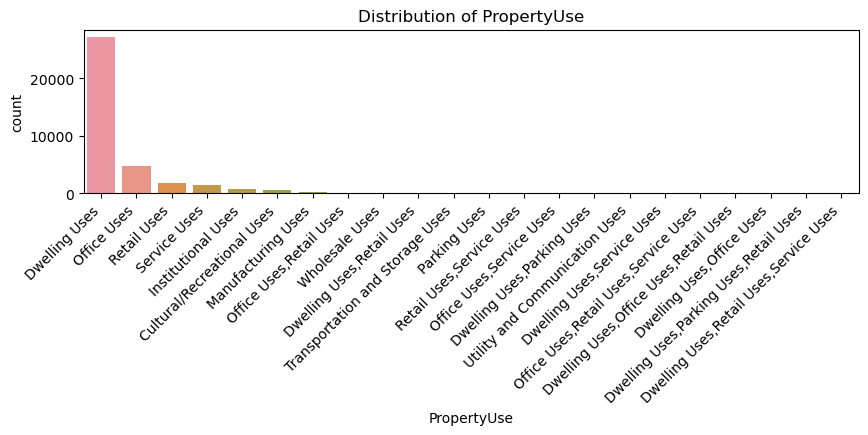

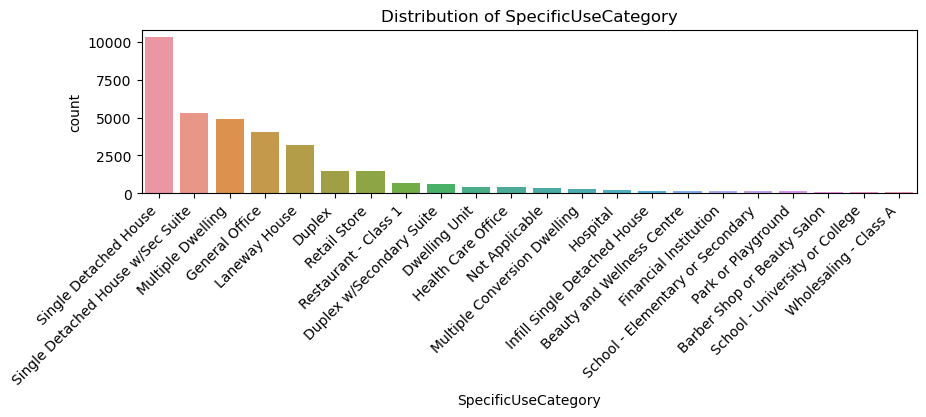

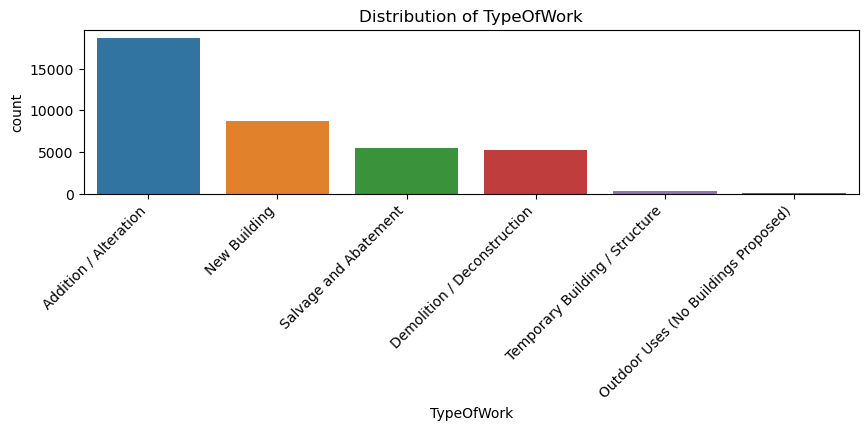

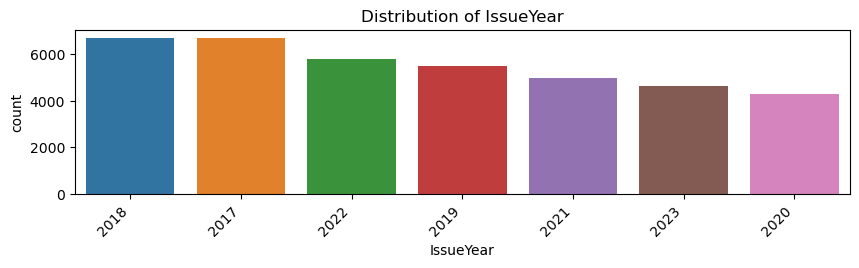

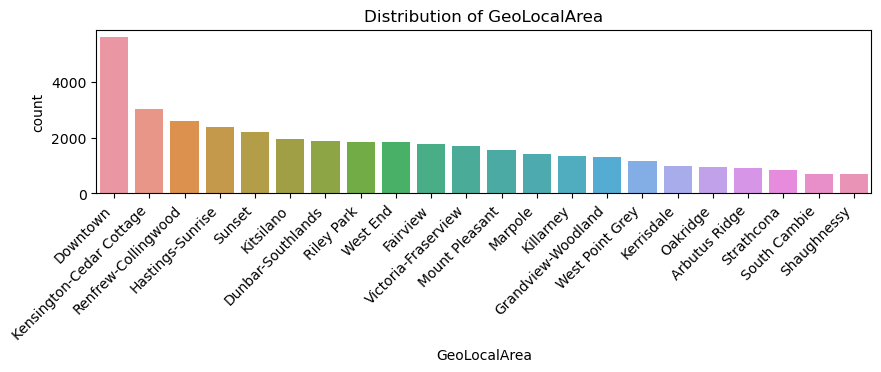

In [112]:
# Loop through each categorical column and create a separate count plot for each one
for i, column in enumerate(categorical_columns, 1):
    
    # Create a new figure with a specified size
    plt.figure(figsize=(10, 20))
    
    # Create a subplot for the current categorical column
    plt.subplot(8, 1, i)
    
    # Create a count plot for the current column, ordering the categories by their counts
    sns.countplot(x=column, data=df, order=df[column].value_counts().head(22).index)
    
    # Set the title of the subplot to indicate the distribution of the current column
    plt.title(f'Distribution of {column}')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.show()

In [113]:
# Loop through each categorical column and print the top 40 most frequent values
for i, column in enumerate(categorical_columns, 1):
    print(df[column].value_counts().head(40))
    print("----------")

PropertyUse
Dwelling Uses                                          27148
Office Uses                                             4800
Retail Uses                                             1874
Service Uses                                            1528
Institutional Uses                                       767
Cultural/Recreational Uses                               598
Manufacturing Uses                                       289
Office Uses,Retail Uses                                  148
Wholesale Uses                                           141
Dwelling Uses,Retail Uses                                125
Transportation and Storage Uses                          119
Parking Uses                                             107
Retail Uses,Service Uses                                  88
Office Uses,Service Uses                                  78
Dwelling Uses,Parking Uses                                71
Utility and Communication Uses                            61
Dwelling Use

### Distribution of numerical columns

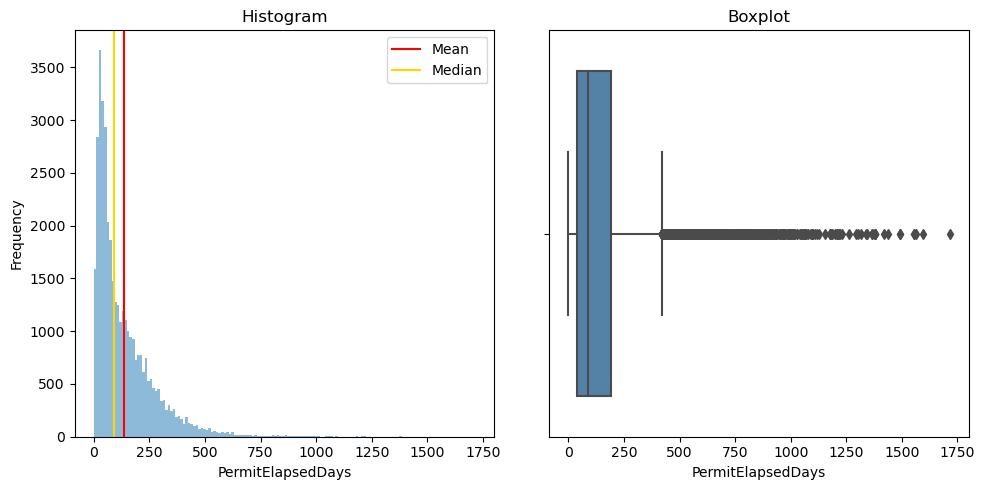

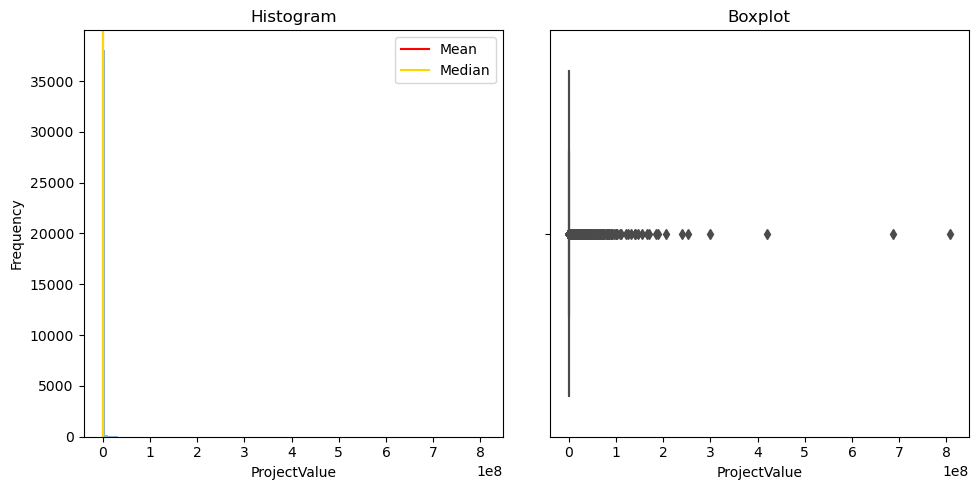

In [114]:
# Loop through each numerical column and create a separate count plot for each one
for col in numerical_columns:
     # Create a new figure with subplots
    plt.subplots(1, 2, figsize=(10, 5))

    # Plot out the histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=150, alpha=0.5)
    plt.title('Histogram')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.axvline(df[col].mean(), c='red', label='Mean')
    plt.axvline(df[col].median(), c='gold', label='Median')
    plt.legend() 
    plt.tight_layout()

    # Plot the boxplot. We can use the seaborn boxplot code for this.
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color="steelblue")
    plt.title('Boxplot')

    plt.show()

In [115]:
# Loop through each numerical column and print descriptive statistics
for i, column in enumerate(numerical_columns, 1):
    print(df[column].describe())
    print("----------")

count    38608.000000
mean       136.249378
std        138.588963
min          0.000000
25%         40.000000
50%         90.000000
75%        192.000000
max       1716.000000
Name: PermitElapsedDays, dtype: float64
----------
count    3.860800e+04
mean     6.577189e+05
std      7.772650e+06
min      0.000000e+00
25%      1.050000e+04
50%      4.696000e+04
75%      2.250000e+05
max      8.071855e+08
Name: ProjectValue, dtype: float64
----------


**Insights:**
1) Predominantly, permits are issued for Dwelling Uses (single detached house, duplex) and Office Uses (General office). The number of permits for Dwelling Uses is approximately five times higher than that for Office Uses.

2) Addition/Alteration is the most common permit type, outnumbering New Building permits by a factor of five.

3) The year 2020 witnessed the lowest number of issued permits, possibly attributed to the impact of COVID-19 lockdown measures.

4) The Downtown area stands out with the highest number of issued permits, indicating increased construction or renovation activity.

5) On average, the waiting time for permit issuance is 136 days. However, the presence of numerous outliers suggests significant variations in processing times.


## Multivariate Visualizations

Let's explore the connection between property value and the waiting time for a permit.

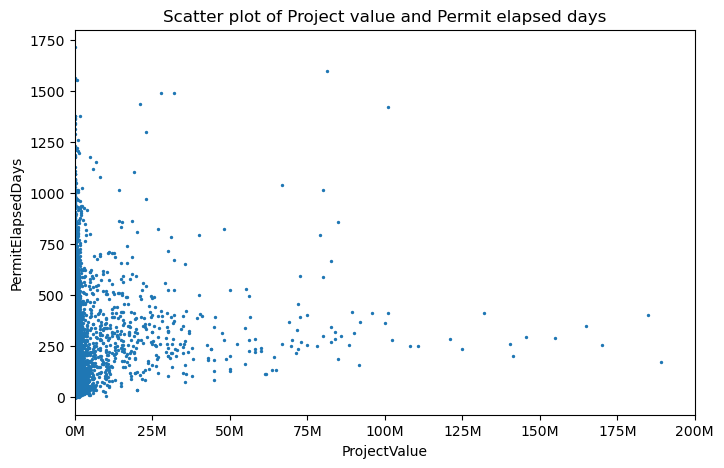

In [116]:
# Define a function to format x-axis labels in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

# Create a new figure with a specified size
plt.figure(figsize=(8, 5))

# Create a scatter plot of 'ProjectValue' vs 'PermitElapsedDays'
# Using the size parameter to help readability
plt.scatter(df['ProjectValue'], df['PermitElapsedDays'], s=2)

# Set labels for x-axis and y-axis
plt.xlabel('ProjectValue')
plt.ylabel('PermitElapsedDays')

# Set the title of the plot
plt.title('Scatter plot of Project value and Permit elapsed days')

# Limit the x-axis range for better readability
plt.xlim(0, 200000000)

# Format the x-axis labels using the millions_formatter function
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Display the plot
plt.show()

What about relationship between the yaer it was issued and the waiting time for a permit.

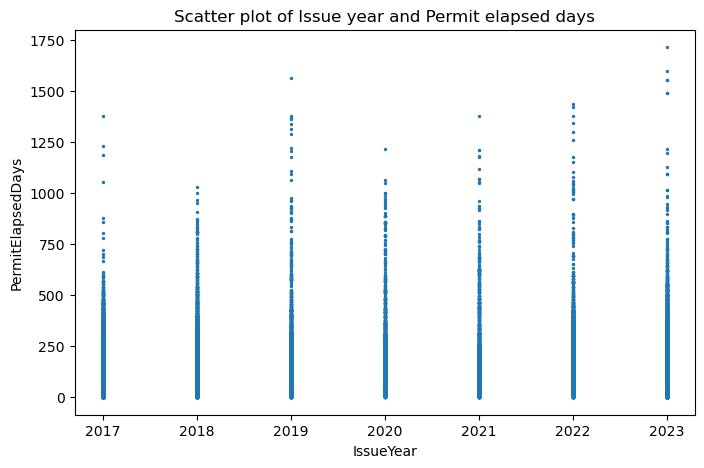

In [117]:
# Create a new figure with a specified size
plt.figure(figsize=(8, 5))

# Create a scatter plot of 'IssueYear' vs 'PermitElapsedDays'
# Using the size parameter to help readability
plt.scatter(df['IssueYear'], df['PermitElapsedDays'], s=2)

# Set labels for x-axis and y-axis
plt.xlabel('IssueYear')
plt.ylabel('PermitElapsedDays')

# Set the title of the plot
plt.title('Scatter plot of Issue year and Permit elapsed days')

# Display the plot
plt.show()

For now let's take a look into how waiting time(dayes) for a permit varies with type of work.

In [118]:
# Group the DataFrame by 'TypeOfWork' and calculate descriptive statistics for 'PermitElapsedDays'
# Sort the result by the count of each group in descending order
df.groupby(["TypeOfWork"])["PermitElapsedDays"].describe().sort_values(by='count',ascending=False)

count        mean         std  min  \
TypeOfWork                                                                   
Addition / Alteration                 18756.0   81.363937  109.746263  0.0   
New Building                           8688.0  247.519337  142.771748  0.0   
Salvage and Abatement                  5537.0   79.125158   73.498157  0.0   
Demolition / Deconstruction            5220.0  216.791762  128.031030  0.0   
Temporary Building / Structure          355.0   24.135211   41.752686  0.0   
Outdoor Uses (No Buildings Proposed)     52.0  105.173077  196.791392  0.0   

                                         25%    50%    75%     max  
TypeOfWork                                                          
Addition / Alteration                  28.00   48.0   90.0  1716.0  
New Building                          153.00  219.0  307.0  1597.0  
Salvage and Abatement                  38.00   62.0   97.0   896.0  
Demolition / Deconstruction           132.00  189.5  271.0  1555.0  
Temporary Building / Structure          2.00    7.0   20.5   389.0  
Outdoor Uses (No Buildings Proposed)   29.75   60.5   90.5  1093.0

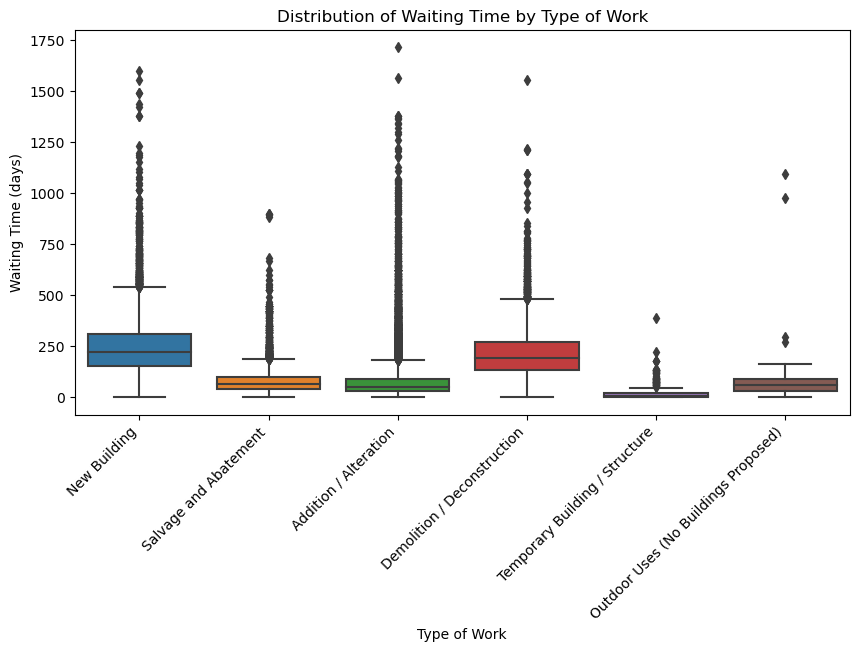

In [119]:
# Create a boxplot to visualize the distribution of waiting time by type of work
plt.figure(figsize=(10, 5))
sns.boxplot(x="TypeOfWork", y="PermitElapsedDays", data=df)
plt.title("Distribution of Waiting Time by Type of Work")
plt.xlabel("Type of Work")
plt.ylabel("Waiting Time (days)")
plt.xticks(rotation=45, ha="right")
plt.show()

### Comparison of Permit Elapsed Days between New Building and Addition / Alteration Categories

In [27]:
# Choose two property use categories for comparison
category_A = "New Building"
category_B = "Addition / Alteration"

# Extract the permit elapsed days for the chosen categories
group_A = df[df["TypeOfWork"] == category_A]["PermitElapsedDays"]
group_B = df[df["TypeOfWork"] == category_B]["PermitElapsedDays"]

# Perform the t-test
statistic, p_value = ttest_ind(group_A, group_B, equal_var=False)

# Display the results
print(f"T-statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between New Building and Addition / Alteration.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: 96.11663213603144
P-value: 0.0
Reject the null hypothesis: There is a significant difference between New Building and Addition / Alteration.


Let's take a look at descriptive statistict of top 22 property use categories by permit elapsed days.

In [28]:
# Group the DataFrame by 'PropertyUse' and calculate descriptive statistics for 'PermitElapsedDays'
# Sort the result by the count of each group in descending order and display the top 22 rows
df.groupby(["PropertyUse"])["PermitElapsedDays"].describe().sort_values(by='count',ascending=False).head(22)

count        mean         std  \
PropertyUse                                                               
Dwelling Uses                           27148.0  158.675335  139.301436   
Office Uses                              4800.0   52.593958   69.728323   
Retail Uses                              1874.0   75.943970   88.299347   
Service Uses                             1528.0   96.678665  120.627032   
Institutional Uses                        767.0   98.627119  125.631789   
Cultural/Recreational Uses                598.0   70.769231  121.528582   
Manufacturing Uses                        289.0  112.799308  125.516991   
Office Uses,Retail Uses                   148.0   99.648649  124.974874   
Wholesale Uses                            141.0   83.971631   90.497746   
Dwelling Uses,Retail Uses                 125.0  170.936000  181.186357   
Transportation and Storage Uses           119.0   98.042017  105.693945   
Parking Uses                              107.0   99.887850  133.790411   
Retail Uses,Service Uses                   88.0   98.579545  113.736206   
Office Uses,Service Uses                   78.0   88.346154   86.903264   
Dwelling Uses,Parking Uses                 71.0  332.802817  228.358904   
Utility and Communication Uses             61.0  146.098361  182.250990   
Dwelling Uses,Service Uses                 38.0  106.315789   98.710361   
Office Uses,Retail Uses,Service Uses       36.0  135.861111  238.727598   
Dwelling Uses,Parking Uses,Retail Uses     30.0  398.100000  283.529157   
Dwelling Uses,Office Uses                  30.0  144.966667  185.940384   
Dwelling Uses,Office Uses,Retail Uses      30.0  241.066667  250.082736   
Dwelling Uses,Retail Uses,Service Uses     26.0  181.461538  245.572837   

                                          min     25%    50%     75%     max  
PropertyUse                                                                   
Dwelling Uses                             0.0   54.00  126.0  223.00  1716.0  
Office Uses                               0.0   22.00   36.0   57.00  1317.0  
Retail Uses                               0.0   32.00   51.0   87.00  1367.0  
Service Uses                              0.0   35.00   62.0  112.25  1564.0  
Institutional Uses                        0.0   33.00   59.0  112.00  1180.0  
Cultural/Recreational Uses                0.0    7.00   34.0   77.00  1184.0  
Manufacturing Uses                        0.0   37.00   70.0  138.00  1005.0  
Office Uses,Retail Uses                   1.0   35.75   56.0   94.25   906.0  
Wholesale Uses                            7.0   33.00   56.0  100.00   697.0  
Dwelling Uses,Retail Uses                 0.0   48.00  119.0  237.00  1093.0  
Transportation and Storage Uses           0.0   36.50   64.0  125.00   757.0  
Parking Uses                              0.0   32.00   60.0  115.50  1070.0  
Retail Uses,Service Uses                  6.0   41.00   61.5  119.50   832.0  
Office Uses,Service Uses                  7.0   34.00   55.5  116.75   408.0  
Dwelling Uses,Parking Uses                2.0  184.00  291.0  416.00  1155.0  
Utility and Communication Uses            0.0   40.00   76.0  169.00   896.0  
Dwelling Uses,Service Uses                6.0   34.75   86.0  138.00   505.0  
Office Uses,Retail Uses,Service Uses     15.0   36.50   61.0  127.75  1302.0  
Dwelling Uses,Parking Uses,Retail Uses  105.0  243.75  318.5  424.00  1491.0  
Dwelling Uses,Office Uses                 9.0   39.00   68.0  178.50   933.0  
Dwelling Uses,Office Uses,Retail Uses    15.0   63.75  136.0  377.00  1002.0  
Dwelling Uses,Retail Uses,Service Uses    0.0   54.75  119.5  219.75  1231.0

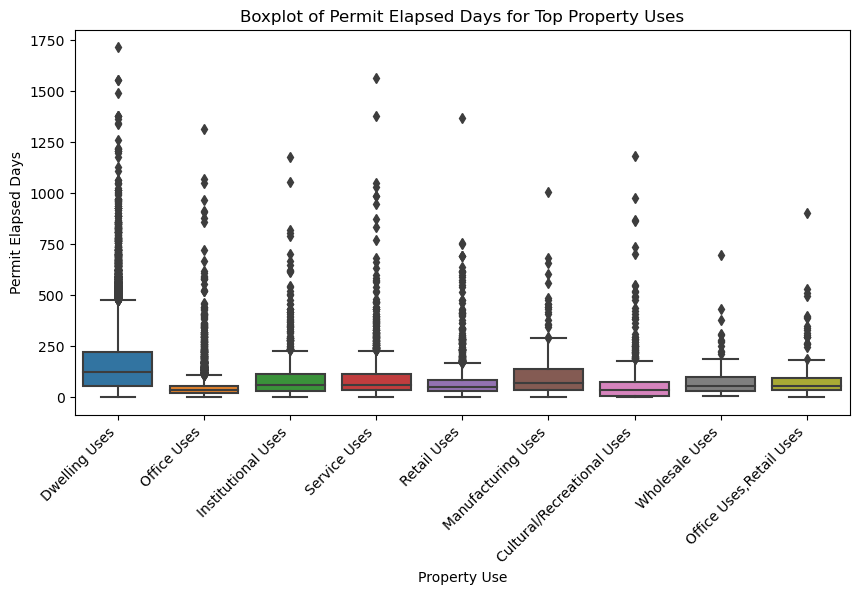

In [29]:
# Create a DataFrame with the top property uses
top_property_use = df.groupby(["PropertyUse"])["PermitElapsedDays"].describe().sort_values(by='count', ascending=False).head(9)

# Create a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='PropertyUse', y='PermitElapsedDays', data=df[df['PropertyUse'].isin(top_property_use.index)])
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Permit Elapsed Days for Top Property Uses')
plt.xlabel('Property Use')
plt.ylabel('Permit Elapsed Days')
plt.show()

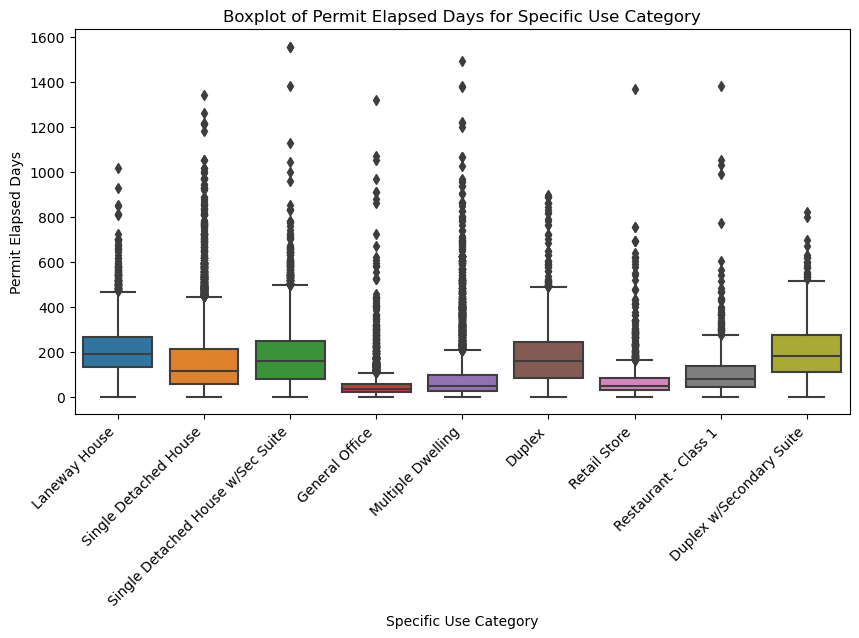

In [30]:
# Create a DataFrame with the top property uses
top_specific_use = df.groupby(["SpecificUseCategory"])["PermitElapsedDays"].describe().sort_values(by='count', ascending=False).head(9)

# Create a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='SpecificUseCategory', y='PermitElapsedDays', data=df[df['SpecificUseCategory'].isin(top_specific_use.index)])
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Permit Elapsed Days for Specific Use Category')
plt.xlabel('Specific Use Category')
plt.ylabel('Permit Elapsed Days')
plt.show()

### Comparison of permit elapsed days between Dwelling Uses and Office Uses categories

In [31]:
# Choose two property use categories for comparison
category_A = "Dwelling Uses"
category_B = "Office Uses"

# Extract the permit elapsed days for the chosen categories
group_A = df[df["PropertyUse"] == category_A]["PermitElapsedDays"]
group_B = df[df["PropertyUse"] == category_B]["PermitElapsedDays"]

# Perform the t-test
statistic, p_value = ttest_ind(group_A, group_B, equal_var=False)

# Display the results
print(f"T-statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between Dwelling Uses and Office Uses.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: 80.7056945878716
P-value: 0.0
Reject the null hypothesis: There is a significant difference between Dwelling Uses and Office Uses.


**Insights:**
1) There is a positive correlation between higher property values and longer waiting times for permits, which is reasonable as more expensive projects often require more thorough analysis.
2) The average waiting time for a new building permit is 248 days, while for Addition/Alteration, it is 81 days. This disparity is expected, considering that new building projects typically involve more complexities.
3) Dwelling Uses exhibit an average waiting time of 159 days, significantly higher than other property uses such as Office Uses, which averages 52 days. This discrepancy may be attributed to a higher volume of Dwelling Uses applications, potentially leading to a shortage of staff resources. Also, the municipal department may prioritize certain types of permits over others based on various criteria. If Dwelling Uses are considered lower priority or face delays in processing, it could lead to longer waiting times.

## Time Series

### Seasonality

Let's explore **seasonality** across multiple years for **created date.**

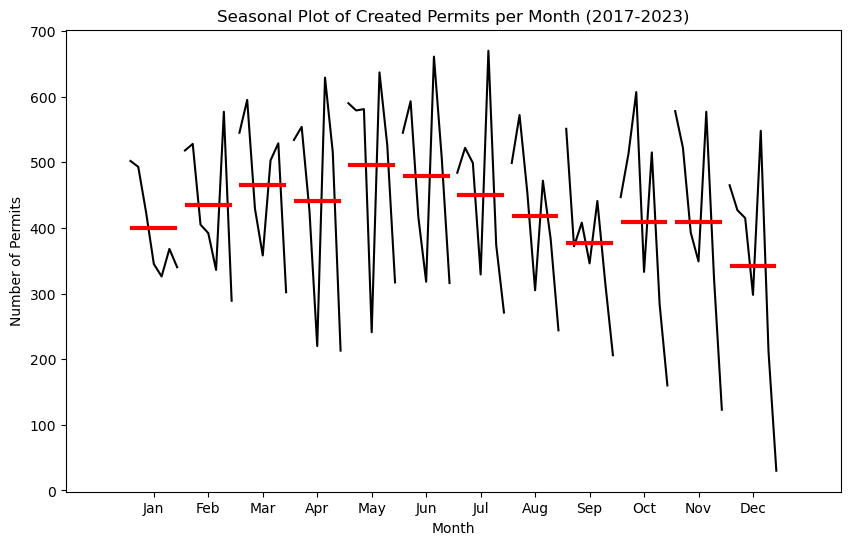

In [32]:
# Convert 'PermitNumberCreatedDate' column to datetime format
df['PermitNumberCreatedDate'] = pd.to_datetime(df['PermitNumberCreatedDate'])

# Filter out data for years 2013-2016
df_season = df.copy()
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year.isin(range(2017, 2024))]

# Set 'PermitNumberCreatedDate' as the index
df_season.set_index('PermitNumberCreatedDate', inplace=True)

# Resample data to get the count of permits per month
monthly_counts = df_season.resample('M').size()

# Create a seasonal plot
fig, ax = plt.subplots(figsize=(10, 6))
month_plot(monthly_counts, ax=ax)

# Add title and axis labels
plt.title('Seasonal Plot of Created Permits per Month (2017-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Permits')
plt.show()


**Insights:**

The red bars show the average for the given month across all years, while each black line represent an individual month and the progression of values across the years. 

I observe a consistent upward trend in monthly permit applications, with May and June consistently exhibiting the highest numbers on average. The sharp decline in the middle can be attributed to the impact of the Covid lockdown. Surprisingly, the year 2023 shows an even lower number of applications compared to the Covid period.

Let's explore **seasonality** across multiple years for **issued date.**

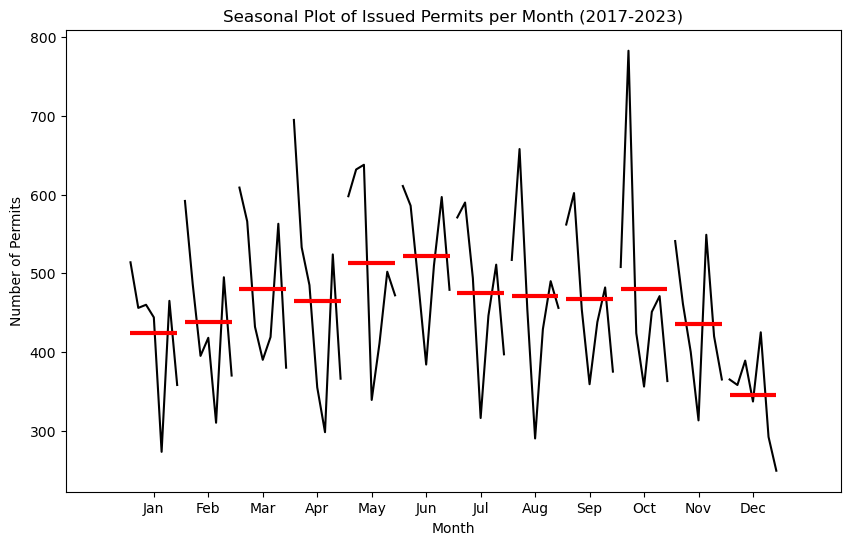

In [33]:
# Assuming df is your DataFrame with 'IssueDate' as a datetime index
df['IssueDate'] = pd.to_datetime(df['IssueDate'])
df_season = df.copy()
df_season.set_index('IssueDate', inplace=True)

# Resample data to get the count of permits per month
monthly_counts_issued = df_season.resample('M').size()

# Create a seasonal plot
fig, ax = plt.subplots(figsize=(10, 6))
month_plot(monthly_counts_issued, ax=ax)

plt.title('Seasonal Plot of Issued Permits per Month (2017-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Permits')
plt.show()


**Insights:**

I observe a consistent upward trend in monthly issued permits, with May and June consistently exhibiting the highest numbers on average. The sharp decline in the middle can be attributed to the impact of the Covid lockdown. The year 2023 shows an  lower number of issued permits, due the lower number of applications.


### Trend-Seasonal Decomposition for PermitNumberCreatedDate

In [34]:
# decompose the time series
decomposition = tsa.seasonal_decompose(monthly_counts, model='additive')

In [35]:
# add the decomposition data
monthly_counts["Trend"] = decomposition.trend
monthly_counts["Seasonal"] = decomposition.seasonal
monthly_counts["Residual"] = decomposition.resid

# A sanity check
monthly_counts.head(50)

PermitNumberCreatedDate
2017-01-31 00:00:00    502
2017-02-28 00:00:00    518
2017-03-31 00:00:00    545
2017-04-30 00:00:00    534
2017-05-31 00:00:00    590
2017-06-30 00:00:00    545
2017-07-31 00:00:00    484
2017-08-31 00:00:00    499
2017-09-30 00:00:00    551
2017-10-31 00:00:00    447
2017-11-30 00:00:00    578
2017-12-31 00:00:00    465
2018-01-31 00:00:00    493
2018-02-28 00:00:00    528
2018-03-31 00:00:00    595
2018-04-30 00:00:00    554
2018-05-31 00:00:00    579
2018-06-30 00:00:00    593
2018-07-31 00:00:00    522
2018-08-31 00:00:00    572
2018-09-30 00:00:00    372
2018-10-31 00:00:00    513
2018-11-30 00:00:00    522
2018-12-31 00:00:00    427
2019-01-31 00:00:00    424
2019-02-28 00:00:00    405
2019-03-31 00:00:00    429
2019-04-30 00:00:00    426
2019-05-31 00:00:00    581
2019-06-30 00:00:00    416
2019-07-31 00:00:00    499
2019-08-31 00:00:00    454
2019-09-30 00:00:00    408
2019-10-31 00:00:00    607
2019-11-30 00:00:00    393
2019-12-31 00:00:00    415
2020

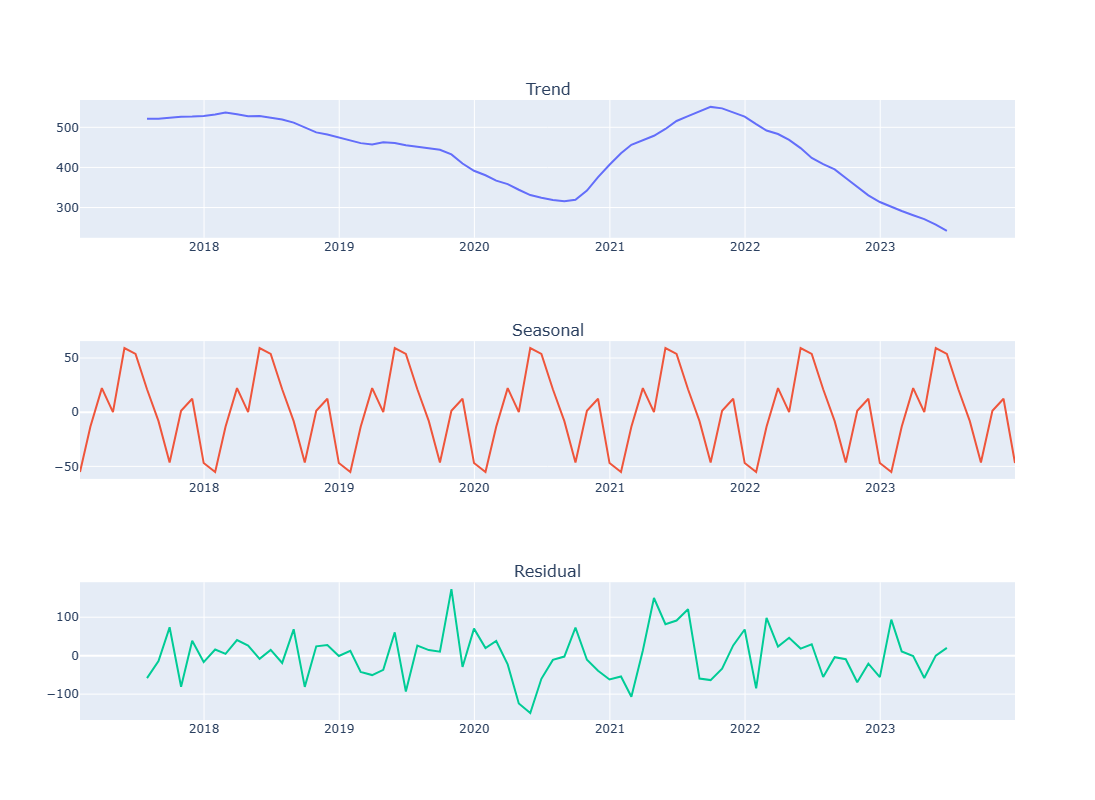

In [36]:
# Define the columns for subplots
cols = ["Trend", "Seasonal", "Residual"]

# Create subplots with specified rows, columns, and subplot titles
fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

# Loop through each column and add trace to the corresponding subplot
for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_counts.index, y=monthly_counts[col]),
        row=i+1,
        col=1
    )

# Update layout settings
fig.update_layout(height=800, width=1200, showlegend=False)

# Display the plot
fig.show()


### Trend-Seasonal Decomposition for IssueDate

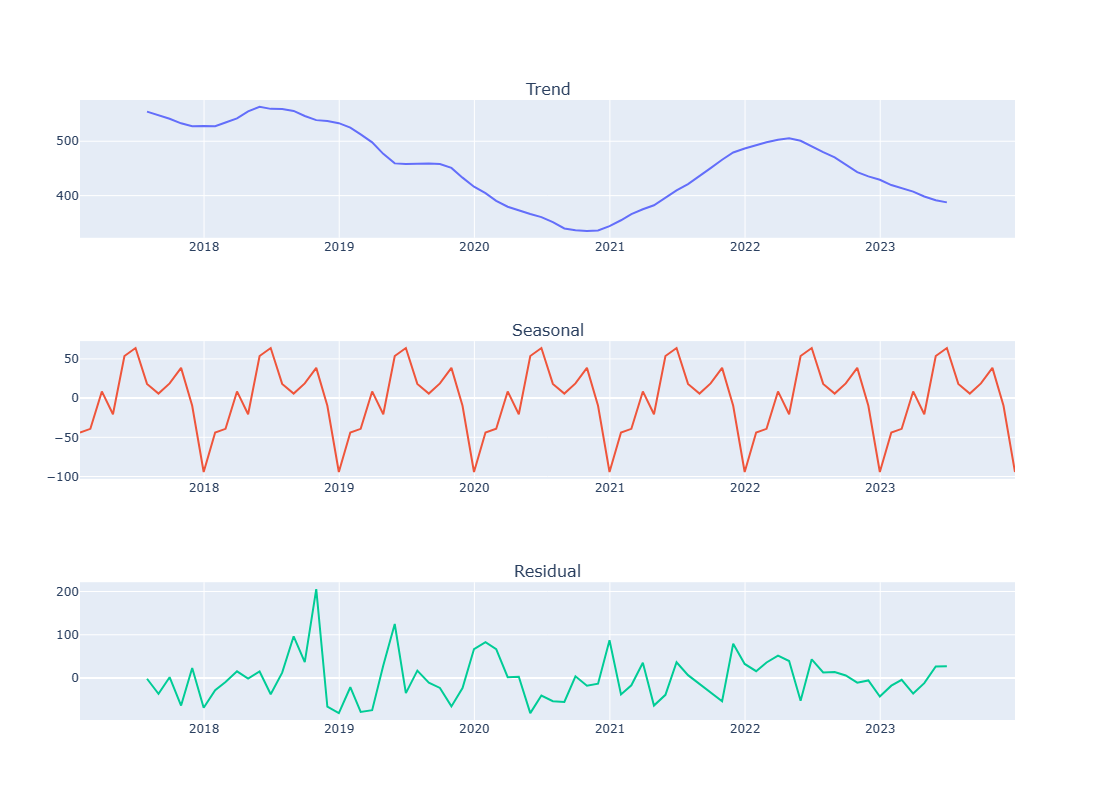

In [37]:
# Perform seasonal decomposition
decomposition = tsa.seasonal_decompose(monthly_counts_issued, model='additive')

# Add the decomposition components to the original DataFrame
monthly_counts_issued["Trend"] = decomposition.trend
monthly_counts_issued["Seasonal"] = decomposition.seasonal
monthly_counts_issued["Residual"] = decomposition.resid

# Define the columns for subplots
cols = ["Trend", "Seasonal", "Residual"]

# Create subplots with specified rows, columns, and subplot titles
fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

# Loop through each column and add trace to the corresponding subplot
for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_counts_issued.index, y=monthly_counts_issued[col]),
        row=i+1,
        col=1
    )

# Update layout settings
fig.update_layout(height=800, width=1200, showlegend=False)

# Display the plot
fig.show()


**Insight:**

After experiencing a decline during the COVID-19 period, the number of permit applications exhibited a subsequent increase around the beginning of 2022. Surprisingly, in 2023, the application count dropped even lower than during the COVID-19 period. It's important to note that the decrease in issued permits in 2023 is directly tied to the overall low level of applications rather than any issues related to permit approval.

# EDA Conclusion

The analysis of permit data reveals valuable insights into the dynamics of construction activities and the permit application process in the given dataset.

**General Insights:**

   **Property Usage and Permit Types:**
   
- Predominantly, permits are issued for Dwelling Uses (single detached house, duplex) and Office Uses (General office). The number of permits for Dwelling Uses is approximately five times higher than that for Office Uses.
        
- Addition/Alteration is the most common permit type, outnumbering New Building permits by a factor of five.

**Yearly Trends:**

- The year 2020 witnessed the lowest number of issued permits, possibly attributed to the impact of COVID-19 lockdown measures.

- The Downtown area stands out with the highest number of issued permits, indicating increased construction or renovation activity.

**Processing Times:**

- On average, the waiting time for permit issuance is 136 days. However, the presence of numerous outliers suggests significant variations in processing times.

**Relationships and Correlations:**

   **Property Values and Waiting Times:**

- There is a positive correlation between higher property values and longer waiting times for permits, which is reasonable as more expensive projects often require more thorough analysis.

- The average waiting time for a new building permit is 248 days, while for Addition/Alteration, it is 81 days. This disparity is expected, considering that new building projects typically involve more complexities.

- Dwelling Uses exhibit an average waiting time of 159 days, significantly higher than other property uses such as Office Uses, which averages 52 days. This discrepancy may be attributed to a higher volume of Dwelling Uses applications, potentially leading to a shortage of staff resources.

**Seasonal Trends:**

   **Monthly Permit Applications:**

- There is a consistent upward trend in monthly permit applications, with May and June consistently exhibiting the highest numbers on average.

- The sharp decline in the middle can be attributed to the impact of the Covid lockdown.

- Surprisingly, the year 2023 shows an even lower number of applications compared to the Covid period.

**Monthly Issued Permits:**

- There is a consistent upward trend in monthly issued permits, with May and June consistently exhibiting the highest numbers on average.

- The sharp decline in the middle can be attributed to the impact of the Covid lockdown.

- The year 2023 shows an even lower number of issued permits compared to the Covid period, due to the lower number of applications.

**Overall Insights:**

After experiencing a decline during the COVID-19 period, the number of permit applications exhibited a subsequent increase around the beginning of 2022. However, surprisingly, in 2023, the application count dropped even lower than during the COVID-19 period. It's important to note that the decrease in issued permits in 2023 is directly tied to the overall low level of applications rather than any issues related to permit approval.

# Feature Engineering

## Drop columns

The following columns can be dropped as they are not crucial for the prediction.

`PermitNumber`: This feature will not be used in the analysis.

`YearMonth`: This feature will not be used in the analysis.

`Geom`: This feature will not be used as it duplicates information present in geo_point_2d.

In [38]:
# Define the columns to be dropped
column_to_drop = ['IssueYear', 'IssueDate', 'PermitNumber', 'YearMonth', 'Geom']

# Drop the specified columns from the DataFrame and assign it to a new DataFrame
df = df.drop(columns=column_to_drop)

## PermitNumberCreatedDate

Let's explore the datetime columns and conduct feature engineering. The `IssueDate` itself may not be crucial and I dropped it above, but extracting the month and date as separate features from `PermitNumberCreatedDate` could enhance predictive modeling.

In [39]:
# A sanity check
df.select_dtypes('datetime').head()

PermitNumberCreatedDate
0              2023-01-05
1              2023-01-06
2              2023-01-06
3              2023-01-06
5              2023-01-09

The `month_sin` and `month_cos` features are used to capture the cyclical nature of time, specifically the month of the year. By encoding the month in this way, you're representing it as a point on a unit circle, where January and December are close together. This encoding helps the model to understand the periodicity of time features like month in a more meaningful way compared to simply using integer labels for months.

In [40]:
# Extract the month from the 'PermitNumberCreatedDate' column
df['Month'] = df['PermitNumberCreatedDate'].dt.month

# Calculate the sine and cosine of the month to encode cyclic behavior
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Drop the original 'PermitNumberCreatedDate' and 'Month' columns
df = df.drop(columns=['PermitNumberCreatedDate', 'Month'])

## Non-numeric columns

Let's examine non-numeric columns and perform feature engineering on them.

In [41]:
# Inspect non-numeric columns
df.select_dtypes('object').head()

TypeOfWork                                 ProjectDescription  \
0           New Building  Low Density Housing - New Building - To constr...   
1  Salvage and Abatement  Low Density Housing - Salvage and Abatement - ...   
2           New Building  Low Density Housing - New Building - To constr...   
3           New Building  Low Density Housing - New Building - To constr...   
5  Addition / Alteration  Field Review - Addition / Alteration - Structu...   

                                    Applicant    PropertyUse  \
0                          Shalindro  Dosanjh  Dwelling Uses   
1  John Keen DBA: Farpoint Architectural Inc.  Dwelling Uses   
2          Embark Homes DBA: Embark Homes LTD  Dwelling Uses   
3      Wayne  Ng DBA: Skymark Engineering Ltd  Dwelling Uses   
5                     Ian Duff DBA: Polycrete    Office Uses   

                 SpecificUseCategory              GeoLocalArea  \
0                      Laneway House       Victoria-Fraserview   
1              Single Detached House  Kensington-Cedar Cottage   
2  Single Detached House w/Sec Suite                  Oakridge   
3                      Laneway House                    Sunset   
5                     General Office                 Kitsilano   

               geo_point_2d  
0  49.2165995, -123.0755831  
1    49.244843, -123.081827  
2  49.2270346, -123.1079161  
3  49.2170343, -123.1041746  
5   49.271989, -123.1470757

In [42]:
# check the number of unique categories in each non-numeric column to determine if the OHE is appropriate
df.select_dtypes('object').nunique()

TypeOfWork                 6
ProjectDescription     36206
Applicant               9169
PropertyUse              140
SpecificUseCategory      786
GeoLocalArea              22
geo_point_2d           19849
dtype: int64

**Summary:**

    `TypeOfWork:` One Hot Encoding is recommended since there are only 6 types of work.

    `ProjectDescription:` Utilize Bag-of-Words (Count) for NLP analysis on project descriptions.

    `Applicant:` Apply Bag-of-Words (Count) technique to process applicant information.

    `PropertyUse:` Preprocess by selecting the top 12 most frequent property uses; replace other categories with 'Others'. Follow with One Hot Encoding.

    `SpecificUseCategory:` Preprocess by selecting the top 22 most frequent specific use categories; replace other categories with 'Others'. Proceed with One Hot Encoding.

    `GeoLocalArea:` Perform One Hot Encoding to handle categorical data.
    
    `geo_point_2d:` Split into separate columns for latitudes and longitudes for further analysis. 

### geo_point_2d

In [43]:
# Split the 'geo_point_2d' column into two separate columns
df[['Latitude', 'Longitude']] = df['geo_point_2d'].str.split(', ', expand=True).astype(float)

# Drop the original 'geo_point_2d' column if needed
df = df.drop(columns=['geo_point_2d'])

### PropertyUse (One Hot Encoding)

In [44]:
# Get the top 12 categories
top_categories = df['PropertyUse'].value_counts().nlargest(12).index

# Replace categories not in the top 12 with 'Others'
df['PropertyUse'] = df['PropertyUse'].apply(lambda x: x if x in top_categories else 'Others')

In [45]:
# A sanity check
df['PropertyUse'].unique()

array(['Dwelling Uses', 'Office Uses', 'Institutional Uses',
       'Service Uses', 'Retail Uses', 'Parking Uses', 'Others',
       'Manufacturing Uses', 'Cultural/Recreational Uses',
       'Wholesale Uses', 'Transportation and Storage Uses',
       'Office Uses,Retail Uses', 'Dwelling Uses,Retail Uses'],
      dtype=object)

### SpecificUseCategory (One Hot Encoding)

In [46]:
# Get the top 12 categories
top_categories = df['SpecificUseCategory'].value_counts().nlargest(22).index

# Replace categories not in the top 12 with 'Others'
df['SpecificUseCategory'] = df['SpecificUseCategory'].apply(lambda x: x if x in top_categories else 'Others')

In [47]:
# A sanity check
df['GeoLocalArea'].unique()

array(['Victoria-Fraserview', 'Kensington-Cedar Cottage', 'Oakridge',
       'Sunset', 'Kitsilano', 'West End', 'Mount Pleasant', 'Kerrisdale',
       'West Point Grey', 'Dunbar-Southlands', 'Downtown', 'Riley Park',
       'Fairview', 'Marpole', 'Renfrew-Collingwood', 'Arbutus Ridge',
       'Strathcona', 'Hastings-Sunrise', 'Shaughnessy', 'Killarney',
       'Grandview-Woodland', 'South Cambie'], dtype=object)

Apply OHE to `TypeOfWork`,`PropertyUse`,`SpecificUseCategory`, `GeoLocalArea` non-numeric features at the same time.

In [48]:
# Initialize the OneHotEncoder
ohe = OneHotEncoder()

# Define the columns to be encoded
column_to_encode = ['TypeOfWork', 'PropertyUse', 'SpecificUseCategory', 'GeoLocalArea']

# Fit and transform the selected columns using OneHotEncoder
encoded_matrix = ohe.fit_transform(df[column_to_encode])

# Convert the encoded matrix to a DataFrame with appropriate column names
ohe_df = pd.DataFrame(encoded_matrix.toarray(), columns=ohe.get_feature_names(), dtype=int)

# Set the index of the new DataFrame to match the original DataFrame
ohe_df.index = df.index

In [49]:
# Drop the original column from the original DataFrame
df = df.drop(columns=column_to_encode)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = df.join(ohe_df)

In [50]:
# A sanity check 
df.columns

Index(['PermitElapsedDays', 'ProjectValue', 'ProjectDescription', 'Applicant',
       'Month_sin', 'Month_cos', 'Latitude', 'Longitude',
       'x0_Addition / Alteration', 'x0_Demolition / Deconstruction',
       'x0_New Building', 'x0_Outdoor Uses (No Buildings Proposed)',
       'x0_Salvage and Abatement', 'x0_Temporary Building / Structure',
       'x1_Cultural/Recreational Uses', 'x1_Dwelling Uses',
       'x1_Dwelling Uses,Retail Uses', 'x1_Institutional Uses',
       'x1_Manufacturing Uses', 'x1_Office Uses', 'x1_Office Uses,Retail Uses',
       'x1_Others', 'x1_Parking Uses', 'x1_Retail Uses', 'x1_Service Uses',
       'x1_Transportation and Storage Uses', 'x1_Wholesale Uses',
       'x2_Barber Shop or Beauty Salon', 'x2_Beauty and Wellness Centre',
       'x2_Duplex', 'x2_Duplex w/Secondary Suite', 'x2_Dwelling Unit',
       'x2_Financial Institution', 'x2_General Office',
       'x2_Health Care Office', 'x2_Hospital',
       'x2_Infill Single Detached House', 'x2_Laneway House

### ProjectDescription (The Bag-of-Words model)

`ProjectDescription` contains detailed text about the project that can be used in the model using the Bag-of-Words model.

In [51]:
# instantiating the independent and dependent variables
X = df.drop(columns="PermitElapsedDays")
y = df["PermitElapsedDays"]

In [52]:
# performing a train_test_split to better evaluate our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

**What tokenizer and text cleaning steps do I include?**

Remove punctuation;

Set to the lower case;

Remove the common stop words;

Perform lemmatization;

Perform stemming;

In [53]:
nltk.download('wordnet')
nltk.download('punkt')

# Initialize Porter Stemmer and WordNet Lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemm = WordNetLemmatizer()

# Define English stopwords
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def my_tokenizer(sentence):
    # Replace newline characters with spaces
    sentence = sentence.replace('\r', ' ').replace('\n', ' ')
    
    # Remove punctuation marks and digits
    sentence = sentence.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    # Tokenize the sentence
    listofwords = sentence.split(' ')
    
    # Initialize lists to store lemmatized and stemmed words
    listoflemmatize_words = []
    listofstemmed_words = []
    
    # Lemmatize each word and remove stopwords
    for word in listofwords:
        if word.lower() not in ENGLISH_STOP_WORDS and word != '':
            lemmatized_word = lemm.lemmatize(word, pos='v')  # Lemmatize verb forms
            listoflemmatize_words.append(lemmatized_word)
    
    # Stem each lemmatized word
    for word in listoflemmatize_words:
        stemmed_word = stemmer.stem(word)
        listofstemmed_words.append(stemmed_word)
    
    return listofstemmed_words


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tatya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tatya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Transform the `ProjectDescription` columns using a CountVectorizer with the following settings: 
- set to lower case because it helps in treating words with different cases as the same, preventing the model from considering them as distinct features;
- use the tokinizer I defined above;
- use unigrams and bigrams as features in the analysis. Bigrams (consecutive pairs of words) as features provides a more comprehensive representation of the text;
- maximize the number of features at 500 because restricting the feature set to 500 ensures a balance between capturing relevant information and maintaining model efficiency;
- tokens used <10 times are dropped from the vocabulary because it can help eliminate noise from the dataset;y.

In [54]:
# Initialize CountVectorizer with specified parameters
bagofwords_pr = CountVectorizer(min_df=10, max_features=500, tokenizer=my_tokenizer, lowercase=True, ngram_range=(1, 3))

# Fit CountVectorizer on the training data
bagofwords_pr.fit(X_train["ProjectDescription"])

# Transform the training and testing data using the fitted CountVectorizer
X_train_pr = bagofwords_pr.transform(X_train["ProjectDescription"])
X_test_pr = bagofwords_pr.transform(X_test["ProjectDescription"])

C:\Users\tatya\anaconda3\envs\plotly_bokeh\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [55]:
# Drop the column 
columns_to_drop = ['ProjectDescription']

# Drop multiple columns in-place
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

C:\Users\tatya\AppData\Local\Temp\ipykernel_10868\3464179820.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tatya\AppData\Local\Temp\ipykernel_10868\3464179820.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
# Add the prefix pd for ProjectDescription for columns
cols = [f'pd_{word}' for word in bagofwords_pr.get_feature_names()]

# Create a DataFrame with the transformed training data and appropriate column names
X_train_pr = pd.DataFrame(columns=cols, data=X_train_pr.toarray(), index=X_train.index)

# Join the original traning dataset and Project Description bag of words.
X_train_extended_with_pr = pd.concat([X_train, X_train_pr], axis=1)

In [57]:
# Create a DataFrame with the transformed testing data and appropriate column names
X_test_pr = pd.DataFrame(columns=cols, data=X_test_pr.toarray(), index=X_test.index)

# Concatenate the original testing dataset and the DataFrame with Project Description bag of words
X_test_extended_with_pr = pd.concat([X_test, X_test_pr], axis=1)

In [58]:
# A sanity check
X_test_extended_with_pr.shape

(3861, 570)

**Top 30 most frequently occurring words in ProjectDescription:**

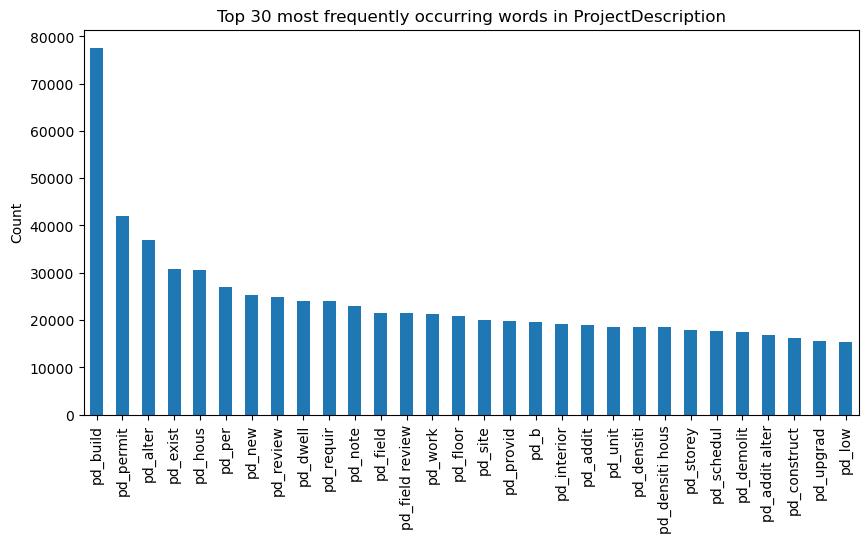

In [59]:
# Create a DataFrame to store word counts
word_counts_pos = pd.DataFrame({"counts": X_train_pr.sum(axis=0)}).sort_values("counts", ascending=False)

# Plot the top 30 most frequently occurring words
word_counts_pos.head(30).plot(kind="bar", figsize=(10, 5), legend=False)
plt.title("Top 30 most frequently occurring words in ProjectDescription")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

### Applicant (The Bag-of-Words model)

The same process above is applied to the Applicant column.

In [60]:
# Initialize CountVectorizer with specified parameters and custom tokenizer
bagofwords_ap = CountVectorizer(min_df=10, max_features=500, tokenizer=my_tokenizer, lowercase=True, ngram_range=(1, 3))

# Fit CountVectorizer on the training data for 'Applicant' column
bagofwords_ap.fit(X_train_extended_with_pr["Applicant"])

# Transform the training and testing data using the fitted CountVectorizer
X_train_ap = bagofwords_ap.transform(X_train_extended_with_pr["Applicant"])
X_test_ap = bagofwords_ap.transform(X_test_extended_with_pr["Applicant"])


C:\Users\tatya\anaconda3\envs\plotly_bokeh\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [61]:
# Drop the column 
columns_to_drop = ['Applicant']

# Drop multiple columns in-place
X_train_extended_with_pr.drop(columns=columns_to_drop, inplace=True)
X_test_extended_with_pr.drop(columns=columns_to_drop, inplace=True)

In [62]:
# Generate column names with 'ap_' prefix for 'Applicant' bag of words
cols = [f'ap_{word}' for word in bagofwords_ap.get_feature_names()]

# Create a DataFrame with the transformed training data and appropriate column names
X_train_ap = pd.DataFrame(columns=cols, data=X_train_ap.toarray(), index=X_train_extended_with_pr.index)

# Concatenate the original training dataset and the DataFrame with 'Applicant' bag of words
X_train_extended_with_ap = pd.concat([X_train_extended_with_pr, X_train_ap], axis=1)

In [63]:
# Create a DataFrame with the transformed testing data and appropriate column names
X_test_ap = pd.DataFrame(columns=cols, data=X_test_ap.toarray(), index=X_test_extended_with_pr.index)

# Concatenate the original testing dataset and the DataFrame with 'Applicant' bag of words
X_test_extended_with_ap = pd.concat([X_test_extended_with_pr, X_test_ap], axis=1)

**Top 30 most frequently occurring words in Applicant:**

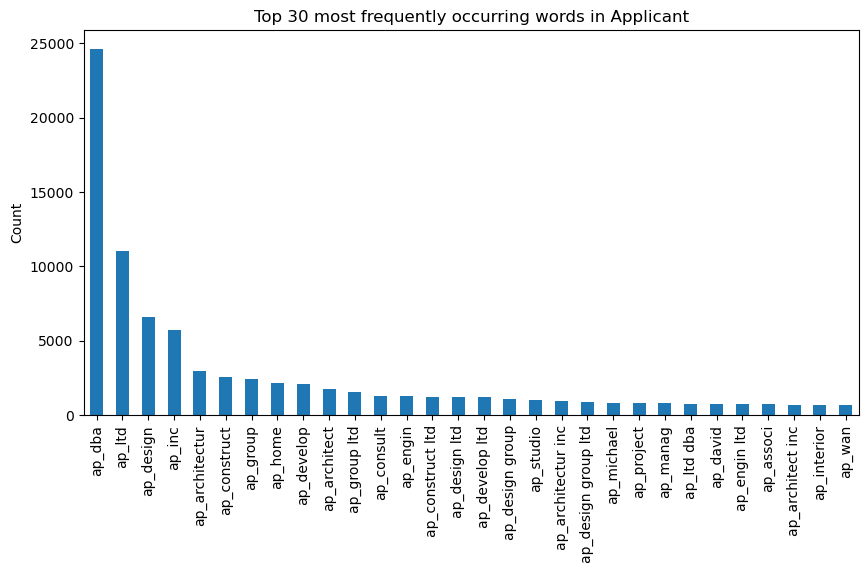

In [64]:
# Create a DataFrame to store word counts for 'Applicant' bag of words
word_counts_pos = pd.DataFrame({"counts": X_train_ap.sum(axis=0)}).sort_values("counts", ascending=False)

# Plot the top 30 most frequently occurring words
word_counts_pos.head(30).plot(kind="bar", figsize=(10, 5), legend=False)
plt.title("Top 30 most frequently occurring words in Applicant")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [65]:
# Save the CountVectorizer model for Applicant column to a file that will be used in Web Application
with open('streamlit/models/bagofwords_ap_model.pkl', 'wb') as file:
    pickle.dump(bagofwords_ap, file)
    
# Save the CountVectorizer model for Project Description column to a file that will be used in Web Application
with open('streamlit/models/bagofwords_pr_model.pkl', 'wb') as file:
    pickle.dump(bagofwords_pr, file)

# Baseline models

For the base models, the linear regression, ridge regression, decision tree and polynomial regression are trained without perfect tuning and cross-validation.

In [66]:
# Assign the extended training and testing datasets to X_train and X_test
X_train = X_train_extended_with_ap
X_test = X_test_extended_with_ap

In [67]:
# A sanity check
X_train.shape

(34747, 1069)

In [68]:
# A sanity check
X_test.shape

(3861, 1069)

Based on EDA, there are a lot of outliers, so Robust scaler is used.

In [69]:
# Instantiate the Robust scaler because there are a lot of outliers
RS = RobustScaler()

# Fit the scaler
RS.fit(X_train)

# Transform the training and test sets 
X_train_scaled = RS.transform(X_train)
X_test_scaled = RS.transform(X_test)

In [70]:
# Save the Scaler model to a file in order to use it in Web Application
with open('streamlit/models/robust_scaler.pkl', 'wb') as file:
    pickle.dump(RS, file)

## Linear Regression model

In [71]:
# 1. Instantiate the model
linear_regression_model = LinearRegression()

# 2. Fit the model
linear_regression_model.fit(X_train_scaled, y_train)

# 3. Score on the training data 
print(linear_regression_model.score(X_train_scaled, y_train))

# 4. Score on the testing data
print(linear_regression_model.score(X_test_scaled, y_test))

# Make predictions on the training and testing data
y_train_pred = linear_regression_model.predict(X_train_scaled)
y_test_pred = linear_regression_model.predict(X_test_scaled)

0.44883981024135844
-274576071194166.5


In [72]:
## Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 63.58843284666437
Mean Squared Error: 10626.980430921227
R-squared: 0.44883981024135844

Testing Metrics:
Mean Absolute Error: 36297846.96958789
Mean Squared Error: 5.086979345657276e+18
R-squared: -274576071194166.5


Training Metrics:

Mean Absolute Error (MAE): On average, the baseline model's predictions on the training set are off by approximately 64 days.

Mean Squared Error (MSE): The average squared difference between the model's predictions and the actual values on the training set is around 10627.

R-squared: The R-squared value of approximately 0.45 indicates that around 45% of the variance in the 'PermitElapsedDays' variable is explained by the model on the training set.

Testing Metrics:

Mean Absolute Error (MAE): On average, the model's predictions on the testing set are off by approximately 161,512,297 days. This unusually high MAE suggests significant issues with the model's performance on the testing set, likely indicating overfitting or other problems such as `multicollinearity`.

Mean Squared Error (MSE): The average squared difference between your model's predictions and the actual values on the testing set is around 1.0071882301591436e+20, indicating extremely large errors in prediction. This suggests severe issues with model generalization.

R-squared: The R-squared value of approximately -5.44e+15 is implausible and indicates severe problems with model performance on the testing set. This negative R-squared value suggests that the model performs worse than a model that simply predicts the mean of the target variable.arge errors in prediction. This suggests severe issues with model generalization.

In [73]:
model_summaries = pd.DataFrame(columns=['Train MAE', 'Test MAE'])
model_summaries.loc['all features, robust scaler, linear regression'] = [ mean_absolute_error(y_train, y_train_pred),  mean_absolute_error(y_test, y_test_pred)]
model_summaries

Train MAE      Test MAE
all features, robust scaler, linear regression  63.588433  3.629785e+07

## Ridge model

Ridge regression is useful when multicollinearity is present among the predictors. Let's try that model.

In [74]:
# Create a Lasso regression model: 
ridge_model = Ridge(alpha=1.0) 

# Fit the model to the training data
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the training and testing data
y_train_pred = ridge_model.predict(X_train_scaled)
y_test_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 63.619925108591055
Mean Squared Error: 10641.07530671458
R-squared: 0.4481087903183063

Testing Metrics:
Mean Absolute Error: 65.00107934636746
Mean Squared Error: 11264.014079291062
R-squared: 0.3920107549860887


In [75]:
model_summaries.loc['all features, robust scaler, ridge'] = [ mean_absolute_error(y_train, y_train_pred),  mean_absolute_error(y_test, y_test_pred)]
model_summaries

Train MAE      Test MAE
all features, robust scaler, linear regression  63.588433  3.629785e+07
all features, robust scaler, ridge              63.619925  6.500108e+01

## Decision Tree model

In [76]:
# Create a DecisionTreeRegressor model
decision_tree_model = DecisionTreeRegressor(max_depth = 8, random_state=42)

# Fit the model to the training data
decision_tree_model.fit(X_train_scaled, y_train)

# Make predictions on the training and testing data
y_train_pred = decision_tree_model.predict(X_train_scaled)
y_test_pred = decision_tree_model.predict(X_test_scaled)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 62.852909748826654
Mean Squared Error: 10346.868255152885
R-squared: 0.4633676134074364

Testing Metrics:
Mean Absolute Error: 64.46908858906001
Mean Squared Error: 11911.864565595723
R-squared: 0.35704221488328236


In [77]:
model_summaries.loc['all features, robust scaler, max depth 8, decision tree'] = [ mean_absolute_error(y_train, y_train_pred),  mean_absolute_error(y_test, y_test_pred)]
model_summaries

Train MAE      Test MAE
all features, robust scaler, linear regression      63.588433  3.629785e+07
all features, robust scaler, ridge                  63.619925  6.500108e+01
all features, robust scaler, max depth 8, decis...  62.852910  6.446909e+01

## Polynomial Regression

### PCA 

PCA resolves concerns associated with elevated dimensionality, collinearity, noise, and regularization. Moreover, Polynomial regression encounters limitations in managing numerous columns on a laptop due to memory constraints.

In [78]:
# Perform PCA with 65 principal components
pca = PCA(n_components=50)

# Transform training and testing data using PCA
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [79]:
# Get the explained variance ratios
explained_var_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_var = np.cumsum(explained_var_ratio)

# Print the explained variance for each component and cumulative explained variance for the first 20 components
for i in range(50):
    print(f"Component {i + 1}: Explained Variance = {explained_var_ratio[i]:.4f}, Cumulative Explained Variance = {cumulative_explained_var[i]:.4f}")

Component 1: Explained Variance = 0.9324, Cumulative Explained Variance = 0.9324
Component 2: Explained Variance = 0.0131, Cumulative Explained Variance = 0.9455
Component 3: Explained Variance = 0.0069, Cumulative Explained Variance = 0.9524
Component 4: Explained Variance = 0.0029, Cumulative Explained Variance = 0.9553
Component 5: Explained Variance = 0.0025, Cumulative Explained Variance = 0.9578
Component 6: Explained Variance = 0.0021, Cumulative Explained Variance = 0.9599
Component 7: Explained Variance = 0.0019, Cumulative Explained Variance = 0.9619
Component 8: Explained Variance = 0.0016, Cumulative Explained Variance = 0.9635
Component 9: Explained Variance = 0.0013, Cumulative Explained Variance = 0.9648
Component 10: Explained Variance = 0.0012, Cumulative Explained Variance = 0.9660
Component 11: Explained Variance = 0.0012, Cumulative Explained Variance = 0.9672
Component 12: Explained Variance = 0.0010, Cumulative Explained Variance = 0.9682
Component 13: Explained V

In [80]:
# Get the loadings
feature_names  = X_train.columns.tolist()
loadings = pca.components_
for i in range(50):
    component_loadings = loadings[i]
    main_variables = [feature_names[j] for j in range(len(feature_names)) if abs(component_loadings[j]) > 0.2]  # Adjust the threshold as needed
    print(f"Main variables for Component {i + 1}: {main_variables}")

Main variables for Component 1: ['ProjectValue']
Main variables for Component 2: ['pd_build']
Main variables for Component 3: []
Main variables for Component 4: ['pd_dwell', 'pd_suit']
Main variables for Component 5: ['pd_abat', 'pd_salvag', 'pd_suit']
Main variables for Component 6: ['pd_deconstruct', 'pd_demolit', 'pd_requir']
Main variables for Component 7: ['pd_hous', 'pd_laneway', 'pd_laneway hous']
Main variables for Component 8: ['pd_b', 'pd_peng', 'pd_schedul', 'pd_schedul b']
Main variables for Component 9: []
Main variables for Component 10: []
Main variables for Component 11: ['pd_bp', 'pd_floor', 'pd_new', 'pd_th']
Main variables for Component 12: ['pd_access', 'pd_new', 'pd_number']
Main variables for Component 13: ['pd_dwell', 'pd_new']
Main variables for Component 14: ['pd_dwell', 'pd_suit', 'pd_th', 'pd_unit']
Main variables for Component 15: ['pd_th']
Main variables for Component 16: ['pd_floor', 'pd_new', 'pd_unit']
Main variables for Component 17: ['pd_unit']
Main va

### Train model

C:\Users\tatya\anaconda3\envs\plotly_bokeh\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning:

Ill-conditioned matrix (rcond=1.10582e-23): result may not be accurate.



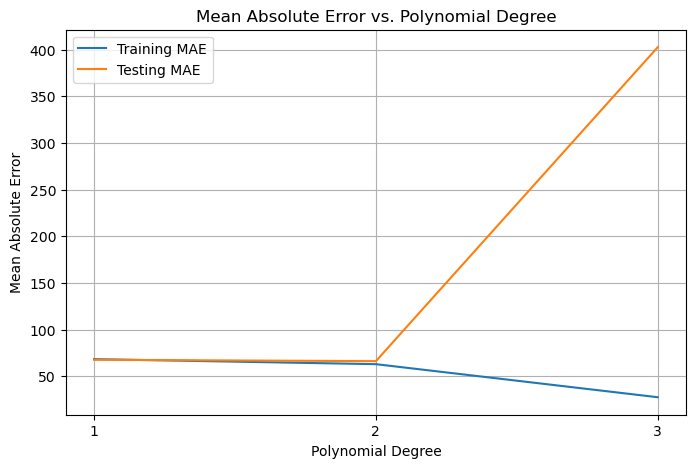

In [81]:
degrees = [1, 2, 3]
train_mae_list = []
test_mae_list = []

for degree in degrees:
    # Create a pipeline with PolynomialFeatures and Ridge Regression
    model = make_pipeline(PolynomialFeatures(degree), Ridge())  

    # Fit the model to the training data
    model.fit(X_train_pca, y_train)

    # Make predictions on the training and testing data
    y_train_pred = model.predict(X_train_pca)
    y_test_pred = model.predict(X_test_pca)

    # Compute Mean Absolute Error for training and testing data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Append MAE to lists
    train_mae_list.append(train_mae)
    test_mae_list.append(test_mae)

# Plot MAE vs. Degree
plt.figure(figsize=(8, 5))
plt.plot(degrees, train_mae_list, label='Training MAE')
plt.plot(degrees, test_mae_list, label='Testing MAE')
plt.title('Mean Absolute Error vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Absolute Error')
plt.xticks(degrees)
plt.legend()
plt.grid(True)
plt.show()

As you can see above, with 3 degrees of polynomial features, the model is overfitted. Let's train model with 2 degree of polynomial features.

In [82]:
# Define the degree of polynomial features
degree = 2

# Create a pipeline with PolynomialFeatures and Ridge Regression
model = make_pipeline(PolynomialFeatures(degree), Ridge())  # You can adjust the alpha parameter for Ridge regularization

# Fit the model to the training data
model.fit(X_train_pca, y_train)

# Make predictions on the training and testing data
y_train_pred = model.predict(X_train_pca)
y_test_pred = model.predict(X_test_pca)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 63.03169862021783
Mean Squared Error: 10417.622543431318
R-squared: 0.45969799651040044

Testing Metrics:
Mean Absolute Error: 66.25715833738136
Mean Squared Error: 11738.732633028445
R-squared: 0.36638722743639196


In [83]:
model_summaries.loc['PCA 50, robust scaler, degree 2, Polynomial'] = [ mean_absolute_error(y_train, y_train_pred),  mean_absolute_error(y_test, y_test_pred)]
model_summaries

Train MAE      Test MAE
all features, robust scaler, linear regression      63.588433  3.629785e+07
all features, robust scaler, ridge                  63.619925  6.500108e+01
all features, robust scaler, max depth 8, decis...  62.852910  6.446909e+01
PCA 50, robust scaler, degree 2, Polynomial         63.031699  6.625716e+01

# XGBoost Regressor model

Neural Networks can offer great flexibility and performance on large datasets,but XGBoost is often a more practical choice for smaller datasets due to its simplicity, efficiency, and ease of use in terms of training, tuning and interpretability. Thus, there are only 40k record in the data set, I will train and tune XGBoost.

With a dataset of 34747 rows and 1069 columns, where most of the columns represent bag-of-words features, here's a suggested approach for parameter tuning and cross-validation:

learning_rate: Start with a small value (e.g., 0.3 or lower) and tune it along with other parameters.
max_depth: Experiment with different values, but avoid very deep trees to prevent overfitting.
subsample and colsample_bytree:` These parameters control the fraction of data and features used for each boosting round. Try values around 0.8 to 1.0 for subsample and colsample_bytree.
n_estimators: The number of boosting rounds. 
Regularization parameters like gamma, reg_alpha, and reg_lambda can also be tuned.

Due to the size of the dataset, I may opt for a faster cross-validation strategy such as k-fold cross-validation with a smaller value of k (e.g., 3). This will reduce the computational cost while still providing a reasonable estimate of model performance.

### Tuning n_estimators

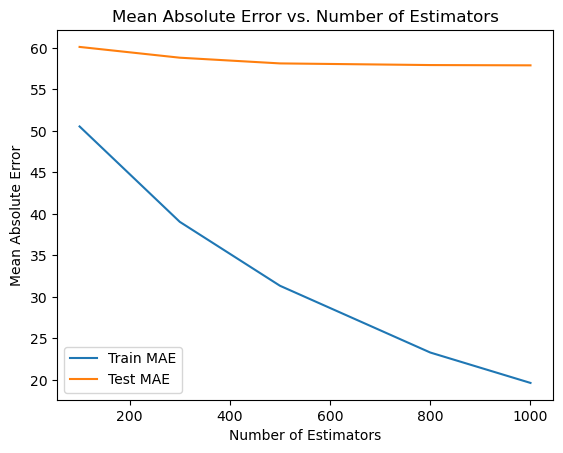

Time taken for running the models: 942.946186542511 seconds


In [84]:
# Record start time
start_time = time.time()

param_grid = {
    'n_estimators': [100, 300, 500, 800, 1000]
}

# Define lists to store MAE values
train_mae = []
test_mae = []

# Loop through different values of n_estimators
for n in param_grid['n_estimators']:
    # Define the XGBRegressor 
    xgb_model = xgb.XGBRegressor(n_estimators=n)
    
    # Fit the model
    xgb_model.fit(X_train_scaled, y_train)
    
    # Make predictions on the training and testing data
    y_train_pred = xgb_model.predict(X_train_scaled)
    y_test_pred = xgb_model.predict(X_test_scaled)
    
    # Calculate MAE for training and testing data
    train_mae.append(mean_absolute_error(y_train, y_train_pred))
    test_mae.append(mean_absolute_error(y_test, y_test_pred))

# Plot MAE values
plt.plot(param_grid['n_estimators'], train_mae, label='Train MAE')
plt.plot(param_grid['n_estimators'], test_mae, label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Number of Estimators')
plt.legend()
plt.show()

# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print("Time taken for running the models:", elapsed_time, "seconds")

The model with 100 estimators is not exhibiting overfitting while others are, it suggests that the complexity of the model with 100 estimators is appropriate for the dataset, resulting in a better balance between bias and variance compared to models with higher numbers of estimators.

### Hyperparameter tuning

In [85]:
# Record start time
start_time = time.time()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5],
    'min_child_weight': [3, 5],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [100],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0]
}

# Define the XGBRegressor 
xgb_model = xgb.XGBRegressor()

# Perform Grid Search with 3-fold cross-validation and early stopping
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours
elapsed_hours = elapsed_time / 3600

print("Time taken for running the model:", elapsed_hours, "hours")

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 1.0}
Time taken for running the model: 18.856444160275988 hours


### Train the best XGBoost model

In [86]:
# Train the model with best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [87]:
# Make predictions on the training and testing data
y_train_pred = best_xgb_model.predict(X_train_scaled)
y_test_pred = best_xgb_model.predict(X_test_scaled)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 53.95017322772988
Mean Squared Error: 7315.360930709142
R-squared: 0.6205944157955803

Testing Metrics:
Mean Absolute Error: 59.616842241434355
Mean Squared Error: 9905.831776681198
R-squared: 0.46532034310824766


In [88]:
model_summaries.loc['all features, robust scaler, 3 cross validation, grid search, XGBoost'] = [ mean_absolute_error(y_train, y_train_pred),  mean_absolute_error(y_test, y_test_pred)]
model_summaries

Train MAE      Test MAE
all features, robust scaler, linear regression      63.588433  3.629785e+07
all features, robust scaler, ridge                  63.619925  6.500108e+01
all features, robust scaler, max depth 8, decis...  62.852910  6.446909e+01
PCA 50, robust scaler, degree 2, Polynomial         63.031699  6.625716e+01
all features, robust scaler, 3 cross validation...  53.950173  5.961684e+01

### Model Interpretation

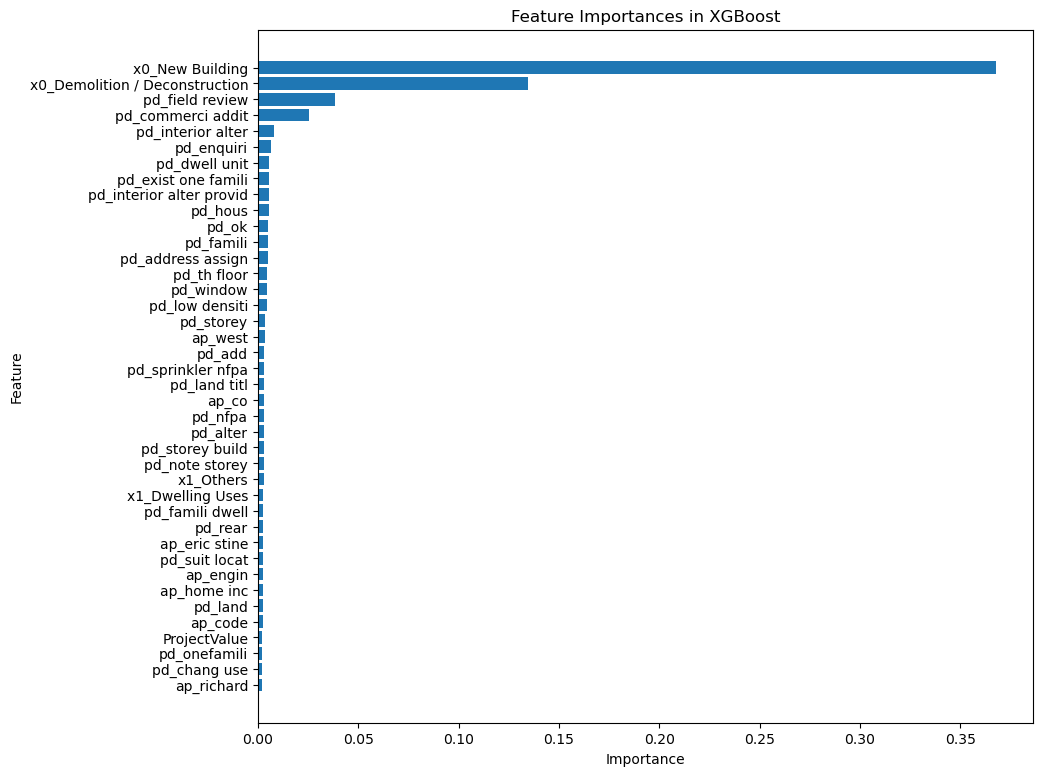

In [89]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 20 important features
feature_importance_df = feature_importance_df.head(40)
# Example: Sorting by importance and then by the length of feature name
feature_importance_df = feature_importance_df.sort_values(by=['Importance', 'Feature'], ascending=[True, False])

# Plot feature importances (optional)
plt.figure(figsize=(10, 9))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in XGBoost')
plt.show()

The feature importance values represent the contribution of each feature to the prediction of the estimated time to get a building permit. Here's an interpretation of the top features based on their importance:

`x0_New Building:` This feature is the most important predictor for estimating the time to get a building permit. It likely indicates whether the application is for a new building project, which seems to significantly influence the permit timeline.

`x0_Demolition / Deconstruction:` This feature ranks second in importance. It suggests that applications related to demolition or deconstruction projects also have a notable impact on the permit timeline.

`pd_field review:` This feature indicates the necessity of field reviews during the permit process. Its importance suggests that field reviews play a significant role in determining the permit timeline.

`pd_commerci addit:` This feature likely represents commercial additions to existing buildings. The presence of commercial additions appears to influence the permit timeline.

`pd_interior alter` This feature refers to interior alterations, which also affect the permit timeline but to a lesser extent compared to other factors.

It can be useful for identifying the most influential features in the model but may not capture complex interactions or non-linear relationships between features, so, let's try SHAP.

## SHAP

 98%|===================| 34145/34747 [00:59<00:01]        

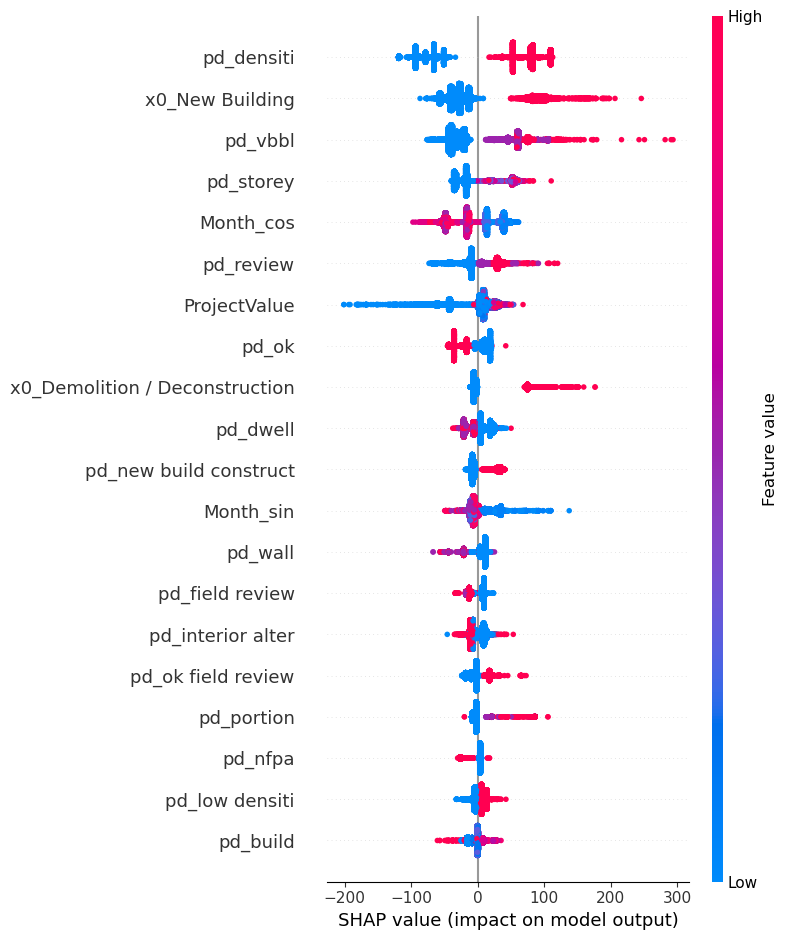

In [90]:
# Get the feature names from your DataFrame or from X_train if it's a DataFrame
feature_names = X_train.columns.tolist()

# Initialize the SHAP explainer with feature names
explainer = shap.Explainer(best_xgb_model, X_train, feature_names=feature_names)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

Keep in mind that SHAP values provide insights into the contribution of each feature to individual predictions and do not necessarily indicate a causal relationship.

`ProjectValue:`

Positive SHAP value: If the SHAP value for ProjectValue is positive, it suggests that permits associated with higher project values tend to take more days to obtain. This aligns with the intuition that larger or more complex projects might involve more scrutiny, require additional permits, or necessitate a longer review process.

A negative SHAP value for ProjectValue would indicate the opposite. Permits for projects with lower values are associated with fewer days to get approval. 

By looking at the distribution of colors for ProjectValue on the x-axis:

Mostly red: This suggests a positive SHAP value, aligning with the first scenario (more days for higher project values).

Mostly blue: This suggests a negative SHAP value, aligning with the second scenario (fewer days for lower project values).

Mix of colors: This indicates a more nuanced relationship where ProjectValue might influence permit wait times in a complex way, depending on other feature combinations.

`x0_New_Building` and `x0_Demolition`:
If the SHAP value for x0_New_Building is positive, it suggests that permits for new buildings (where this feature equals 1) are associated with a greater number of days to get approval compared to other permit types (where this feature equals 0). This aligns with the common notion that new construction projects might involve a more complex permitting process due to factors like:

Additional considerations for infrastructure and utilities.

Need for compliance with building codes and zoning regulations.

Potential environmental impact assessments.

Negative SHAP value: The permits for new buildings are associated with fewer days to get approval because it is other type of permit.

The other permit types (represented by x0_New_Building = 0) involving more complex renovations or alterations.

Look at the position of x0_New_Building on the x-axis and the color of the corresponding bar.

Mostly red: This suggests a positive SHAP value, indicating more days for new building permits.

Mostly blue: This suggests a negative SHAP value, indicating fewer days for other permit types.

`pd_density`
if the project description mentions density, it may lead to a longer permit processing time due to additional precautions or considerations required for projects in densely populated areas.

`pd_vbbl` -  Vancouver Building By-law
the presence of "pd_vbbl" in the project description could potentially lead to a longer permit processing time. This feature likely indicates references to the Vancouver Building By-law in the project description. Compliance with building by-laws may require additional scrutiny or steps in the permit approval process, thereby contributing to delays in obtaining the permit.

`Month_sin`
There is a seasonal pattern here, which were explored before.

if a project is planned to be built in `Downtown` or `Fairview`, it might take more time to obtain the permit compared to other areas. This could be due to various factors such as higher population density, stricter regulations, or more complex approval processes in these areas.

In [91]:
# Save the model to a file to use it in Web Application
with open('streamlit/models/model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

<div id="container" style="position:relative;">
<div style="position:relative; float:right">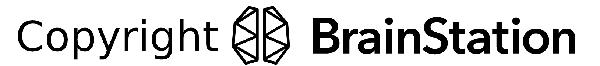
</div>
</div>
